In [ ]:
import memo_py as me
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

##### test for select_models function
- maybe use the introduction model from figure 1
- 3 models with 2, 5, 15 steps respectively
- create some data with 5-steps model
- is this fast/handy enough for a test?
- run in sequential mode/not parallel

=> test seems to work but is a bit expensive, maybe add later

In [2]:
### create data from 5-steps model
t = [
    {'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 5}
    ]

net = me.Network('net_div_g5')
net.structure(t)

num_iter = 100
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

In [3]:
data = me.Data('data_test_select_models')
data.load(['X_t',], time_values, sims, bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with known values (from a num_iter=100 simulation)
data.data_mean = np.array([[[1.         , 3.73      ]],
                           [[0.01       , 0.15406761]]])
data.data_variance = np.array([[[0.         , 2.36070707]],
                               [[0.01       , 0.32208202]]])

In [4]:
print(data.data_mean)
print(data.data_variance)
print(data.data_covariance)

[[[1.         3.73      ]]

 [[0.01       0.15406761]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[]


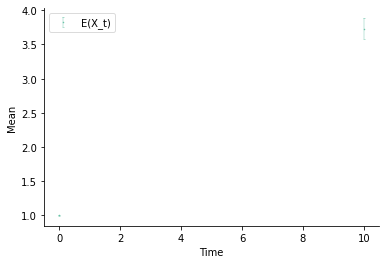

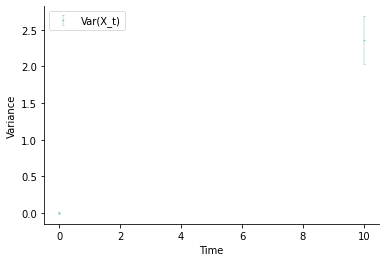

In [5]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)

In [6]:
### define models for selection
net2 = me.Network('net_div_g2')
net2.structure([{'start': 'X_t', 'end': 'X_t',
             'rate_symbol': 'l',
             'type': 'S -> S + S',
             'reaction_steps': 2}])

net5 = me.Network('net_div_g5')
net5.structure([{'start': 'X_t', 'end': 'X_t',
             'rate_symbol': 'l',
             'type': 'S -> S + S',
             'reaction_steps': 5}])

net15 = me.Network('net_div_g15')
net15.structure([{'start': 'X_t', 'end': 'X_t',
              'rate_symbol': 'l',
              'type': 'S -> S + S',
              'reaction_steps': 15}])

# important note: theta_bounds are reduced here to
# prevent odeint warning at high steps
networks = [net2, net5, net15]
variables = [{'X_t': ('X_t', )}]*3
initial_values = [{'X_t': 1.0}]*3
theta_bounds = [{'l': (0.0, 0.5)}]*3


In [7]:
### run selection (sequentially)
for __ in range(3):
    est_res = me.selection.select_models(networks, variables, initial_values,
                                            theta_bounds, data, parallel=False)
    print([est.bay_est_log_evidence for est in est_res])


[-10.615398937004953, 4.713178737418544, -5.926613074607677]



[-10.615332013439911, 4.76965901953526, -6.049582228860745]



[-10.77349654729197, 4.641977588280665, -5.949680667657648]


In [7]:
est_res = me.selection.select_models(models, data, parallel=False) # False (usually here)

In [9]:
for __ in range(10):
    est_res = me.selection.select_models(models, data, parallel=False)
    print([est.bay_est_log_evidence for est in est_res])


[-10.629916697804973, 4.7325886118420755, -5.956029975676918]



[-10.707752281691006, 4.648483811563277, -5.904935097433867]



[-10.660052905403797, 4.786992306046756, -5.865460195018101]



[-10.560456631689906, 4.712198906183986, -6.024845876715448]



[-10.67465188224791, 4.739031922471972, -5.832238436663494]



[-10.688286571898711, 4.796078612214922, -5.866083545090796]



[-10.674939299757629, 4.763798403008956, -5.869504378082593]



[-10.706803542779763, 4.758241853964541, -5.921262356541525]



[-10.55770560556853, 4.770112513127923, -5.9405505492747315]



[-10.660075345658038, 4.832557590020761, -5.869471476946568]


In [10]:
evid_summary = np.array([
    [-10.629916697804973, 4.7325886118420755, -5.956029975676918],
    [-10.707752281691006, 4.648483811563277, -5.904935097433867],
    [-10.660052905403797, 4.786992306046756, -5.865460195018101],
    [-10.560456631689906, 4.712198906183986, -6.024845876715448],
    [-10.67465188224791, 4.739031922471972, -5.832238436663494],
    [-10.688286571898711, 4.796078612214922, -5.866083545090796],
    [-10.674939299757629, 4.763798403008956, -5.869504378082593],
    [-10.706803542779763, 4.758241853964541, -5.921262356541525],
    [-10.55770560556853, 4.770112513127923, -5.9405505492747315],
    [-10.660075345658038, 4.832557590020761, -5.869471476946568]
])
print(evid_summary.shape)
print(np.mean(evid_summary, axis=0))
print(np.std(evid_summary, axis=0)*6)

(10, 3)
[-10.65206408   4.75400845  -5.90503819]
[0.30803495 0.28754652 0.3252738 ]


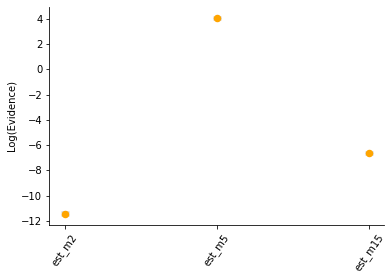

In [18]:
me.plots.selection_plot(est_res)

In [19]:
me.selection.compute_model_probabilities(est_res)

array([1.97803966e-07, 9.99975631e-01, 2.41710544e-05])

In [18]:
print(np.array([est.bay_est_params_conf for est in est_res]))

print(est_res[0].bay_est_log_likelihood_max)
print(est_res[1].bay_est_log_likelihood_max)
print(est_res[2].bay_est_log_likelihood_max)

print(est_res[0].bay_log_likelihood_norm)
print(est_res[1].bay_log_likelihood_norm)
print(est_res[2].bay_log_likelihood_norm)

[[[0.15403995 0.14659241 0.16079126]]

 [[0.21181266 0.20239213 0.22030757]]

 [[0.23227569 0.21840278 0.24577387]]]
-6.655917426977538
8.536409735755383
-2.583752295846338
8.537899031472271
8.537899031472271
8.537899031472271


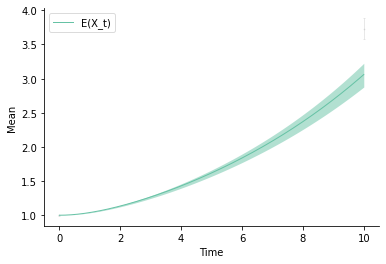

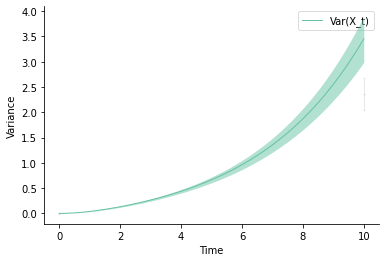

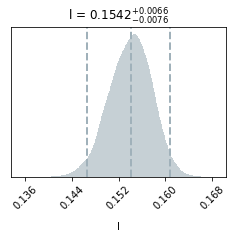

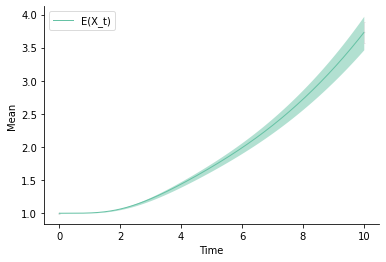

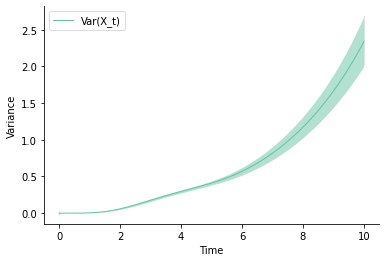

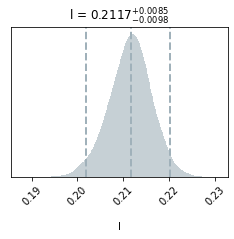

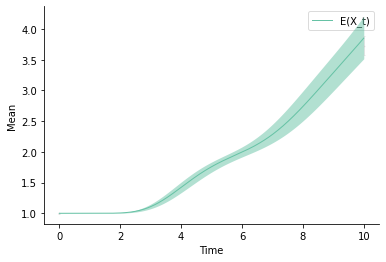

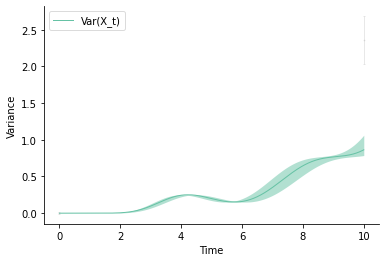

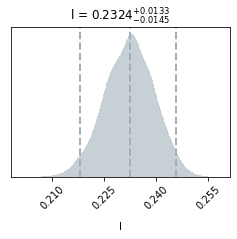

In [20]:
me.plots.est_bestfit_mean_plot(est_res[0])
me.plots.est_bestfit_variance_plot(est_res[0])
me.plots.est_corner_kernel_plot(est_res[0])

me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_kernel_plot(est_res[1])

me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])

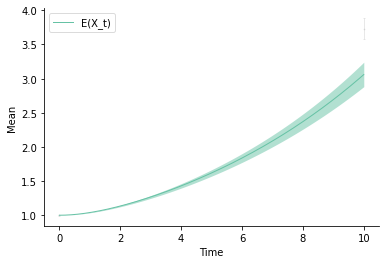

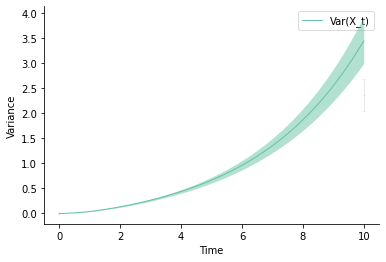

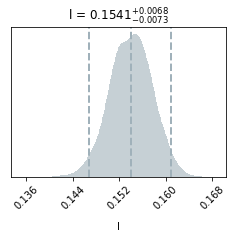

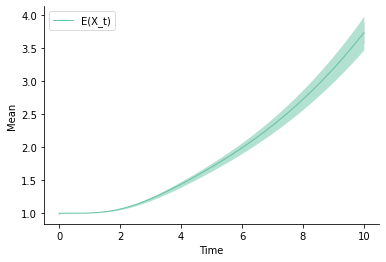

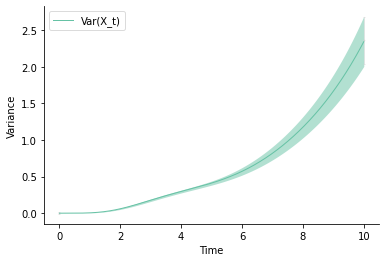

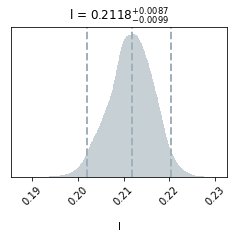

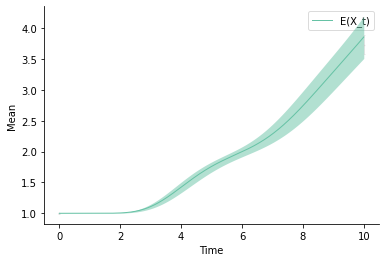

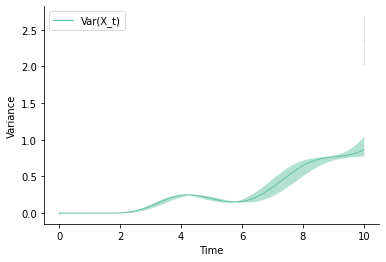

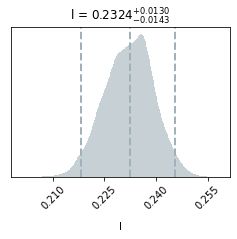

In [8]:
me.plots.est_bestfit_mean_plot(est_res[0])
me.plots.est_bestfit_variance_plot(est_res[0])
me.plots.est_corner_kernel_plot(est_res[0])

me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_kernel_plot(est_res[1])

me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])

##### check warning
/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
  
=> bug found: this warning occured when l values were too high *and* at the same time very few time values were used in the odeint (2 in the estimation)

In [7]:
models_check = [('m15', t15, s)]
est_check = me.selection.select_models(models_check, data)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
est = est_check[0]
np.mean(est.bay_est_samples_weighted)
# 0.23235173968206016

In [70]:
t = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 15}]

net = me.Network('net_check')
net.structure(t)

network_setup = {
    'initial_values': {'X_t': 1.0}, 
    'theta_bounds': {'l': (0.0, 1.0)}, 
    'mean_only': False,
    'variables': {'X_t': ('X_t', )}
}

mcmc_setup = {
    'nlive':                    1000, # 250 # 1000
    'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
    'bound':                    'multi',
    'sample':                   'unif'
}

est = me.Estimation('est_check', net, data)
est.estimate(network_setup, mcmc_setup)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [71]:
np.mean(est.bay_est_samples_weighted)

0.2322282859721292

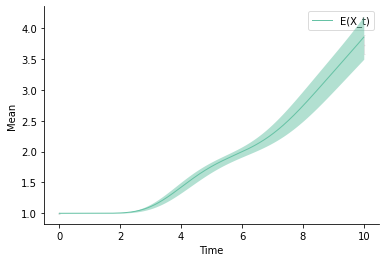

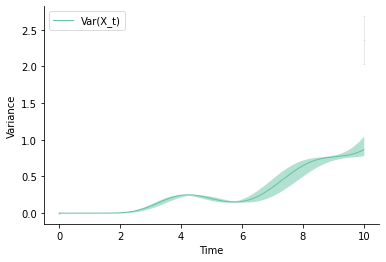

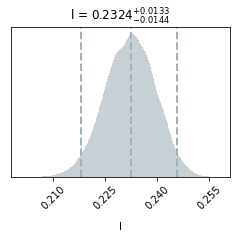

In [72]:
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_corner_kernel_plot(est)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


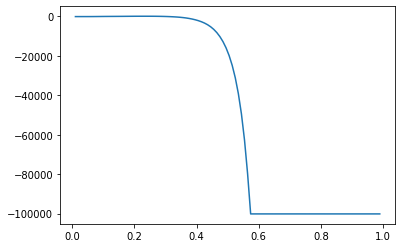

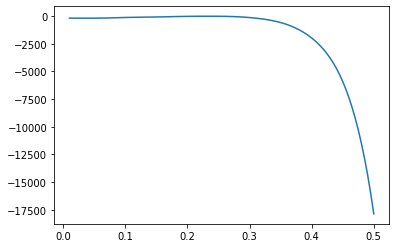

In [75]:
# check some likelihoods manually
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

# warning
plt.figure()
x_vals = np.linspace(0.01, 0.99, num=100, endpoint=True)
plt.plot(x_vals, np.array([est.log_likelihood(np.array([x]), 
                initial_values, time_values, variables, 
               data.data_mean, data.data_variance, 
                data.data_covariance) for x in x_vals]))

# no warning
plt.figure()
x_vals = np.linspace(0.01, 0.5, num=100, endpoint=True)
plt.plot(x_vals, np.array([est.log_likelihood(np.array([x]), 
                initial_values, time_values, variables, 
               data.data_mean, data.data_variance, 
                data.data_covariance) for x in x_vals]))

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


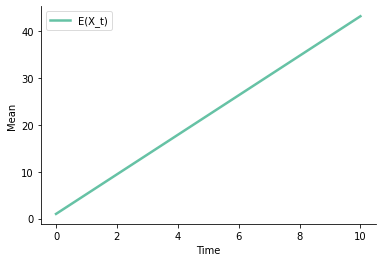

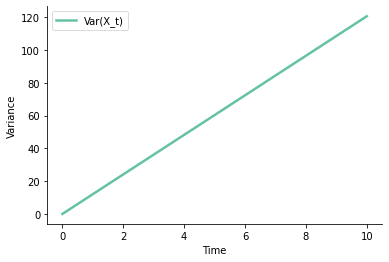

[{'module': 'module_0', 'start-end': ('X_t', 'X_t'), 'start-end_ident': ('Z_0', 'Z_0'), 'sym_rate': 'l', 'sym_rate_ident': 'theta_0', 'type': 'S -> S + S', 'module_steps': 15}]


In [69]:
net = me.Network('net_check')
net.structure(t15)

initial_values = {'X_t': 1}
theta_values = {'l': 0.9}
time_values = np.linspace(0.0, 10.0, num=2, endpoint=True)
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)

sim.simulate('moments', initial_values, theta_values, 
             time_values, variables, estimation_mode=False)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)

print(net.net_modules)

In [13]:
print(sim.sim_moments.theta_numeric)
type(sim.sim_moments.theta_numeric)

[0.26]


numpy.ndarray

In [34]:
from scipy.integrate import odeint
from numba import jit
str_for_exec = sim.sim_moments.moment_eqs_template_str

exec(str_for_exec)
_moment_eqs_template = eval('_moment_eqs_template')

moment_system = _moment_eqs_template # sim.sim_moments.moment_system
init = sim.sim_moments.moment_initial_values
time_arr = time_values
theta = np.random.rand(1) # np.array([theta_values['l']])
sol = odeint(moment_system, init, time_arr, args=(theta, ))
sol

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.02165184e-01, 3.45904512e-01, 1.19134040e-01, ...,
        3.75346400e-40, 7.15974825e-42, 1.28299004e-43],
       [2.52169869e-01, 3.47402412e-01, 2.39299858e-01, ...,
        3.03577300e-29, 2.02680435e-30, 1.35626766e-31],
       ...,
       [4.08418084e+01, 3.89975873e+01, 3.72366027e+01, ...,
        7.71629928e+02, 7.36628868e+02, 7.03336644e+02],
       [4.21941266e+01, 4.02888489e+01, 3.84695795e+01, ...,
        8.23618955e+02, 7.86264703e+02, 7.50729816e+02],
       [4.35912346e+01, 4.16228650e+01, 3.97433693e+01, ...,
        8.79109129e+02, 8.39243651e+02, 8.01315330e+02]])

CPUDispatcher(<function _moment_eqs_template at 0x7fd645d1e5f0>)

In [16]:
print(str_for_exec)

def _moment_eqs_template(m, time, theta):
	return np.array([
	-15.0*m[0]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[0]*theta[0] - 15.0*m[1]*theta[0],
	15.0*m[1]*theta[0] - 15.0*m[2]*theta[0],
	15.0*m[14]*theta[0] - 15.0*m[3]*theta[0],
	15.0*m[3]*theta[0] - 15.0*m[4]*theta[0],
	15.0*m[4]*theta[0] - 15.0*m[5]*theta[0],
	15.0*m[5]*theta[0] - 15.0*m[6]*theta[0],
	15.0*m[2]*theta[0] - 15.0*m[7]*theta[0],
	15.0*m[7]*theta[0] - 15.0*m[8]*theta[0],
	15.0*m[8]*theta[0] - 15.0*m[9]*theta[0],
	-15.0*m[10]*theta[0] + 15.0*m[9]*theta[0],
	15.0*m[10]*theta[0] - 15.0*m[11]*theta[0],
	15.0*m[11]*theta[0] - 15.0*m[12]*theta[0],
	15.0*m[12]*theta[0] - 15.0*m[13]*theta[0],
	15.0*m[13]*theta[0] - 15.0*m[14]*theta[0],
	-30.0*m[15]*theta[0] + 60.0*m[21]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[15]*theta[0] - 30.0*m[16]*theta[0] + 30.0*m[35]*theta[0],
	15.0*m[16]*theta[0] - 30.0*m[17]*theta[0] + 30.0*m[48]*theta[0],
	-30.0*m[18]*theta[0] + 15.0*m[29]*theta[0] + 30.0*m[60]*theta[0],
	15.0*m[18]*theta[0] - 30.0*m[19

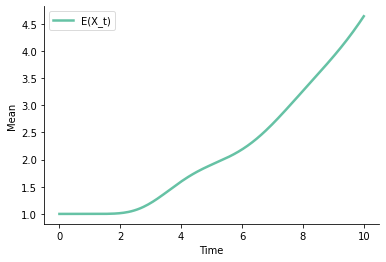

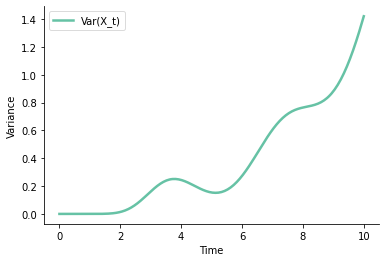

[{'module': 'module_0', 'start-end': ('X_t', 'X_t'), 'start-end_ident': ('Z_0', 'Z_0'), 'sym_rate': 'l', 'sym_rate_ident': 'theta_0', 'type': 'S -> S + S', 'module_steps': 15}]


In [17]:
sim = me.Simulation(net)

sim.simulate('moments', initial_values, theta_values, 
             time_values, variables, estimation_mode=True)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)

print(net.net_modules)

In [13]:
print(sim.sim_moments.moment_eqs_template_str)

@jit(nopython=True)
def _moment_eqs_template(m, time, theta):
	return np.array([
	-15.0*m[0]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[0]*theta[0] - 15.0*m[1]*theta[0],
	15.0*m[1]*theta[0] - 15.0*m[2]*theta[0],
	15.0*m[14]*theta[0] - 15.0*m[3]*theta[0],
	15.0*m[3]*theta[0] - 15.0*m[4]*theta[0],
	15.0*m[4]*theta[0] - 15.0*m[5]*theta[0],
	15.0*m[5]*theta[0] - 15.0*m[6]*theta[0],
	15.0*m[2]*theta[0] - 15.0*m[7]*theta[0],
	15.0*m[7]*theta[0] - 15.0*m[8]*theta[0],
	15.0*m[8]*theta[0] - 15.0*m[9]*theta[0],
	-15.0*m[10]*theta[0] + 15.0*m[9]*theta[0],
	15.0*m[10]*theta[0] - 15.0*m[11]*theta[0],
	15.0*m[11]*theta[0] - 15.0*m[12]*theta[0],
	15.0*m[12]*theta[0] - 15.0*m[13]*theta[0],
	15.0*m[13]*theta[0] - 15.0*m[14]*theta[0],
	-30.0*m[15]*theta[0] + 60.0*m[21]*theta[0] + 30.0*m[6]*theta[0],
	15.0*m[15]*theta[0] - 30.0*m[16]*theta[0] + 30.0*m[35]*theta[0],
	15.0*m[16]*theta[0] - 30.0*m[17]*theta[0] + 30.0*m[48]*theta[0],
	-30.0*m[18]*theta[0] + 15.0*m[29]*theta[0] + 30.0*m[60]*theta[0],
	15.0*m[18]*

##### simple estimation example for testing

In [28]:
# do a minimal model with steps=2 activation and steps=4 division
# three time points maybe

t = [
    {'start': 'X_t', 'end': 'Y_t', 
     'rate_symbol': 'd', 
     'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 4}
    ]

net = me.Network('net_min_2_4')
net.structure(t)

num_iter = 100
initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'d': 0.03, 'l': 0.07}
time_values = np.array([0.0, 20.0, 40.0])
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [29]:
data = me.Data('data_test_est_min_2_4')
data.load(['X_t', 'Y_t'], time_values, sims, 
          bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with fixed values (from a num_iter = 100 simulation)
data.data_mean = np.array([[[1.         ,0.67       ,0.37      ],
                          [0.         ,0.45       ,1.74      ]],
                         [[0.01       ,0.0469473  ,0.04838822],
                          [0.01       ,0.07188642 ,0.1995514 ]]])
data.data_variance = np.array([[[0.         ,0.22333333 ,0.23545455],
                              [0.         ,0.51262626 ,4.03272727]],
                             [[0.01       ,0.01631605 ,0.01293869],
                              [0.01       ,0.08878719 ,0.68612036]]])
data.data_covariance = np.array([[[ 0.         ,-0.30454545 ,-0.65030303]],
                             [[ 0.01        ,0.0303608   ,0.06645246]]])

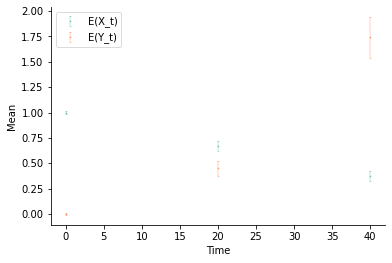

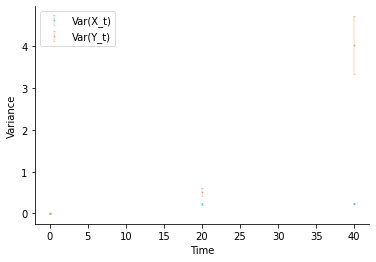

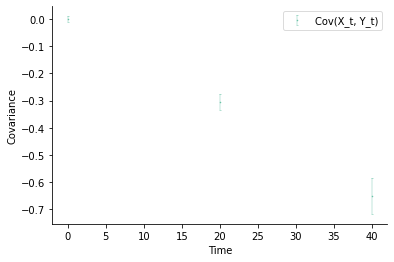

In [34]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)
me.plots.data_covariance_plot(data)

In [37]:
network_setup = {
    'initial_values': {'X_t': 1, 'Y_t': 0},
    'theta_bounds': {'d': (0.0, 0.15), 'l': (0.0, 0.15)}, 
    'mean_only': False,
    'variables': {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
}

mcmc_setup = {
    'nlive':                    1000, # 250 # 1000
    'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
    'bound':                    'multi',
    'sample':                   'unif'
}

est = me.Estimation('est_min_2_4', net, data)
est.estimate(network_setup, mcmc_setup)

In [47]:
print(est.bay_est_log_evidence)
# 28.298372548269864, 28.139812540432732

print(est.bay_est_log_likelihood_max)
# 35.48531419345989

print(np.array([est.bay_est_params_conf]))

28.139812540432732
35.48531419345989
[[[0.02803474 0.02594989 0.03014408]
  [0.07470537 0.06919784 0.07955645]]]


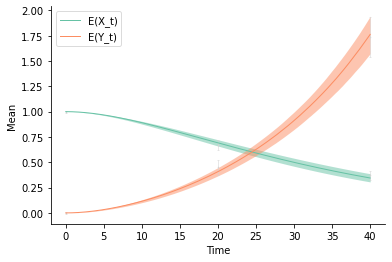

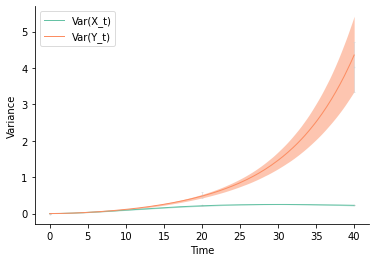

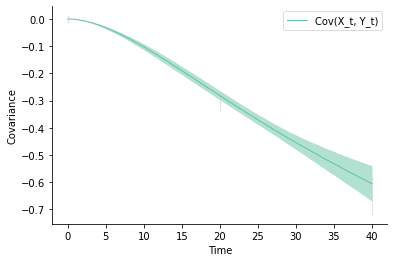

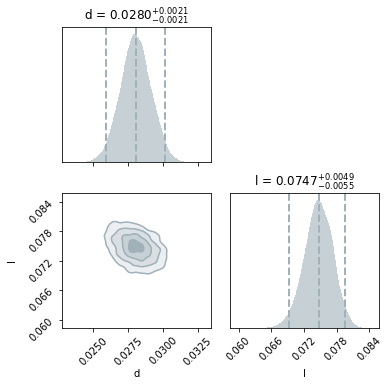

In [40]:
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)
me.plots.est_corner_kernel_plot(est) # d=0.028, l=0.075

In [43]:
print(type(est.bay_nested_sampler))
type(est.bay_nested_sampler_res)

<class 'dynesty.nestedsamplers.MultiEllipsoidSampler'>


dynesty.results.Results

In [49]:
# est is a memopy estimation instance
est.get_model_evidence(est.bay_nested_sampler_res)

(28.139812540432732, 0.11225503808864087)

In [50]:
est.bay_est_log_evidence


28.139812540432732

In [51]:
est.bay_est_log_evidence_error

0.11225503808864087

In [52]:
est.bay_est_log_likelihood_max

35.48531419345989

In [53]:
est.get_maximal_log_likelihood(est.bay_nested_sampler_res)

35.48531419345989

In [54]:
est.bay_est_bayesian_information_criterion

-65.55452798471536

In [55]:
est.compute_bayesian_information_criterion(
                est.data_num_values,
                est.bay_nested_ndims,
                est.bay_est_log_likelihood_max)

-65.55452798471536

In [65]:
est.compute_bayesian_information_criterion(15, 2, 35.49)

-65.56389959779558

In [66]:
est.compute_log_evidence_from_bic(est.bay_est_bayesian_information_criterion)

32.77726399235768

In [67]:
print(est.bay_est_log_evidence)
print(est.bay_est_log_evidence_from_bic)

28.139812540432732
32.77726399235768


In [69]:
est.compute_log_evidence_from_bic(-65.5)

32.75

In [74]:
su, sw, w = est.get_posterior_samples(est.bay_nested_sampler_res)

est.get_posterior_samples(est.bay_nested_sampler_res)

(array([[0.14791189, 0.14857705],
        [0.12864247, 0.14920066],
        [0.13767801, 0.14860021],
        ...,
        [0.02801861, 0.07502377],
        [0.02801369, 0.07502103],
        [0.02802205, 0.07499796]]),
 array([[0.02426309, 0.07119228],
        [0.03200628, 0.06646134],
        [0.03220339, 0.06802025],
        ...,
        [0.02802894, 0.07496195],
        [0.02800815, 0.07502692],
        [0.02801369, 0.07502103]]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.93638169e-06, 9.93651290e-06, 9.93662331e-06]))

In [73]:
print(type(su), type(sw), type(w))
print(su.shape, sw.shape, w.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(12962, 2) (12962, 2) (12962,)


In [80]:
est.bay_est_samples_weighted.shape

(12962, 2)

In [83]:
est.get_confidence_bounds(est.bay_est_samples_weighted)

((0.0280347396878894, 0.02594988652911552, 0.030144084514338445),
 (0.07470536719462752, 0.06919784056074933, 0.07955644971380103))

In [79]:
type(est.get_confidence_bounds(est.bay_est_samples_weighted)[0][0])

numpy.float64

In [82]:
len(est.get_confidence_bounds(est.bay_est_samples_weighted)[0])

3

In [90]:
samples = np.array([[0.2, 3.4], [0.4, 3.2], [0.25, 3.65]])
print(samples.shape)
np.array(est.get_confidence_bounds(samples))

(3, 2)


array([[0.25  , 0.2025, 0.3925],
       [3.4   , 3.21  , 3.6375]])

In [94]:
print(type(est.data_mean_values))
print(est.data_mean_values.shape)
print(est.data_mean_values)
print(type(est.data_var_values))
print(est.data_var_values.shape)
print(est.data_var_values)
print(type(est.data_cov_values))
print(est.data_cov_values.shape)
print(est.data_cov_values)

<class 'numpy.ndarray'>
(2, 2, 3)
[[[1.         0.67       0.37      ]
  [0.         0.45       1.74      ]]

 [[0.01       0.0469473  0.04838822]
  [0.01       0.07188642 0.1995514 ]]]
<class 'numpy.ndarray'>
(2, 2, 3)
[[[0.         0.22333333 0.23545455]
  [0.         0.51262626 4.03272727]]

 [[0.01       0.01631605 0.01293869]
  [0.01       0.08878719 0.68612036]]]
<class 'numpy.ndarray'>
(2, 1, 3)
[[[ 0.         -0.30454545 -0.65030303]]

 [[ 0.01        0.0303608   0.06645246]]]


In [96]:
est.compute_log_likelihood_norm(est.data_mean_values, 
                                est.data_var_values,
                                est.data_cov_values,
                                False)

37.04057852140377

In [98]:
type(est.bay_log_likelihood_norm)

numpy.float64

In [99]:
mean_data = np.array([[[1., 0.67, 0.37],
                       [0., 0.45, 1.74]],
                 [[0.01, 0.0469473, 0.04838822],
                       [0.01, 0.07188642, 0.1995514]]])
var_data = np.array([[[0., 0.22333333, 0.23545455],
                 [0., 0.51262626, 4.03272727]],
                  [[0.01, 0.01631605, 0.01293869],
                     [0.01, 0.08878719, 0.68612036]]])
cov_data = np.array([[[ 0., -0.30454545, -0.65030303]],
                   [[ 0.01, 0.0303608, 0.06645246]]])
print(est.compute_log_likelihood_norm(mean_data, var_data, cov_data, False))
print(est.compute_log_likelihood_norm(mean_data, var_data, cov_data, True))

37.04057852140377
14.028288976285737


In [137]:
theta_values = np.array([0.03, 0.07])
est.log_likelihood(theta_values, est.net_initial_values, 
                   est.data_time_values, est.net_simulation.sim_variables,
                   est.data_mean_values, est.data_var_values, 
                   est.data_cov_values)

32.823084036435795

In [138]:
theta_values = np.array([0.028, 0.075])
#initial_values = {'X_t': 1, 'Y_t': 0}
#time_values = np.array([0.0, 20.0, 40.0])
#sim_variables =  {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
est.log_likelihood(theta_values, est.net_initial_values, 
                   est.data_time_values, est.net_simulation.sim_variables,
                   est.data_mean_values, est.data_var_values, 
                   est.data_cov_values)

35.485136238014185

In [113]:
type(est.log_likelihood(theta_values, initial_values, time_values, sim_variables,
                   est.data_mean_values, est.data_var_values, est.data_cov_values))

numpy.float64

In [141]:
est.net_theta_bounds

array([[0.  , 0.15],
       [0.  , 0.15]])

In [144]:
theta_values = np.array([0.03/0.15, 0.075/0.15])
print(theta_values)
est.prior_transform(theta_values)

[0.2 0.5]


array([0.03 , 0.075])

In [147]:
print(est.net.net_theta_symbolic)
print(est.net.net_rates_identifier)
theta_bounds = {'d': (0.0, 0.15), 'l': (0.0, 0.15)}
print(est.initialise_net_theta_bounds(est.net.net_theta_symbolic, est.net.net_rates_identifier, theta_bounds))

['theta_0', 'theta_1']
{'theta_0': 'd', 'theta_1': 'l'}
[[0.   0.15]
 [0.   0.15]]


In [148]:
type(est.initialise_net_theta_bounds(est.net.net_theta_symbolic, est.net.net_rates_identifier, theta_bounds))

numpy.ndarray

In [149]:
est.net_theta_bounds

array([[0.  , 0.15],
       [0.  , 0.15]])

In [158]:
net_theta_bounds_test = est.initialise_net_theta_bounds(['theta_0', 'theta_1', 'theta_2'], 
                                                        {'theta_0':'p1', 'theta_1':'p2', 'theta_2':'p3'}, 
                                                        {'p1': (0.0, 0.1), 'p2': (0.0, 0.2), 'p3': (0.0, 0.3)})

In [159]:
net_theta_bounds_test.shape

(3, 2)

In [161]:
net_theta_bounds_test

array([[0. , 0.1],
       [0. , 0.2],
       [0. , 0.3]])

In [162]:
est.initialise_net_theta_bounds(
                                        ['theta_0', 'theta_1', 'theta_2'],
                                        {'theta_2':'p3', 'theta_0':'p1', 'theta_1':'p2'},
                                        {'p2': (0.0, 0.1), 'p3': (0.0, 0.2), 'p1': (0.0, 0.3)})

array([[0. , 0.3],
       [0. , 0.1],
       [0. , 0.2]])

In [163]:
est.bay_est_params_median

array([0.02803474, 0.07470537])

In [178]:
est.net_simulation.sim_variables_order

[[('V_0',), ('V_1',)], [('V_0', 'V_0'), ('V_0', 'V_1'), ('V_1', 'V_1')]]

In [166]:
est.net_simulation.sim_variables_identifier

{'V_0': ('X_t', ('X_t',)), 'V_1': ('Y_t', ('Y_t',))}

In [170]:
est.data.data_mean
est.data.data_variance
est.data.data_covariance

array([[[ 0.        , -0.30454545, -0.65030303]],

       [[ 0.01      ,  0.0303608 ,  0.06645246]]])

In [204]:
# est.data.data_mean_order
# est.data.data_variance_order
est.data.data_covariance_order

[{'variables': ('X_t', 'Y_t'), 'summary_indices': 0, 'count_indices': (0, 1)}]

In [218]:
est.match_data_to_network([[('V_0',)], [('V_0', 'V_0')]],
                    {'V_0': ('X_t', ('X_t',))},
                    est.data.data_mean,
                    est.data.data_variance,
                    est.data.data_covariance,
                    est.data.data_mean_order,
                    est.data.data_variance_order,
                    est.data.data_covariance_order)

(array([[[1.        , 0.67      , 0.37      ],
         [0.        , 0.        , 0.        ]],
 
        [[0.01      , 0.0469473 , 0.04838822],
         [0.        , 0.        , 0.        ]]]),
 array([[[0.        , 0.22333333, 0.23545455],
         [0.        , 0.        , 0.        ]],
 
        [[0.01      , 0.01631605, 0.01293869],
         [0.        , 0.        , 0.        ]]]),
 array([[[0., 0., 0.]],
 
        [[0., 0., 0.]]]))

In [214]:
est.match_data_to_network(est.net_simulation.sim_variables_order,
                    est.net_simulation.sim_variables_identifier,
                    est.data.data_mean,
                    est.data.data_variance,
                    est.data.data_covariance,
                    est.data.data_mean_order,
                    est.data.data_variance_order,
                    est.data.data_covariance_order)

(array([[[1.        , 0.67      , 0.37      ],
         [0.        , 0.45      , 1.74      ]],
 
        [[0.01      , 0.0469473 , 0.04838822],
         [0.01      , 0.07188642, 0.1995514 ]]]),
 array([[[0.        , 0.22333333, 0.23545455],
         [0.        , 0.51262626, 4.03272727]],
 
        [[0.01      , 0.01631605, 0.01293869],
         [0.01      , 0.08878719, 0.68612036]]]),
 array([[[ 0.        , -0.30454545, -0.65030303]],
 
        [[ 0.01      ,  0.0303608 ,  0.06645246]]]))

In [215]:
est.match_data_to_network(est.net_simulation.sim_variables_order,
                    {'V_0': ('Y_t', ('Y_t',)), 'V_1': ('X_t', ('X_t',))},
                    est.data.data_mean,
                    est.data.data_variance,
                    est.data.data_covariance,
                    est.data.data_mean_order,
                    est.data.data_variance_order,
                    est.data.data_covariance_order)

(array([[[0.        , 0.45      , 1.74      ],
         [1.        , 0.67      , 0.37      ]],
 
        [[0.01      , 0.07188642, 0.1995514 ],
         [0.01      , 0.0469473 , 0.04838822]]]),
 array([[[0.        , 0.51262626, 4.03272727],
         [0.        , 0.22333333, 0.23545455]],
 
        [[0.01      , 0.08878719, 0.68612036],
         [0.01      , 0.01631605, 0.01293869]]]),
 array([[[ 0.        , -0.30454545, -0.65030303]],
 
        [[ 0.01      ,  0.0303608 ,  0.06645246]]]))

In [182]:
data = me.Data('my_data')
variables = ['A']
time_values = np.linspace(0.0, 4.0, num=5)
count_data = np.array([[[0.0, 0.0, 2.0, 2.0, 4.0], [1.0, 1.0, 1.0, 1.0, 0.0]],
                     [[0.0, 1.0, 2.0, 4.0, 4.0], [1.0, 1.0, 0.0, 0.0, 0.0]],
                     [[0.0, 1.0, 1.0, 4.0, 4.0], [1.0, 1.0, 0.0, 0.0, 0.0]],
                       [[0.0, 0.0, 0.0, 2.0, 4.0], [1.0, 0.0, 0.0, 0.0, 0.0]]])
data.load(variables, time_values, count_data)

In [185]:
data.data_covariance

array([], shape=(2, 0, 5), dtype=float64)

In [194]:
est.data.data_covariance.shape

(2, 1, 3)

In [191]:
len(est.data.data_time_values)

3

In [192]:
est.data.data_variables

['X_t', 'Y_t']

In [201]:
len(est.data.data_mean_order)==est.data.data_mean.shape[2]

False

In [198]:
est.data.data_variance.shape

(2, 2, 3)

In [210]:
list(sim_variables.keys())

['X_t', 'Y_t']

In [213]:
est.net_simulation.sim_variables_order[0]

[('V_0',), ('V_1',)]

In [2]:
data = me.Data('my_data')

In [3]:
type(data)

memo_py.data.Data

In [4]:
net = me.Network('net_test')
data = me.Data('data_test')
est_test = me.Estimation('est_test', net, data)

In [8]:
type(net)

memo_py.network.Network

In [10]:
init_vals = [{'X_t': 1.0}]*2

In [14]:
all(isinstance(e, dict) for e in init_vals)

True

In [15]:
type(True)

bool

In [23]:
net = me.Network('net_div_g5')
net.structure([{'start': 'X_t', 'end': 'X_t',
                'rate_symbol': 'l',
                'type': 'S -> S + S', 'reaction_steps': 5}])

num_iter = 100
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

data = me.Data('data_test_select_models')
data.load(['X_t',], time_values, sims, bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with known values (from a num_iter=100 simulation)
data.data_mean = np.array([[[1.         , 3.73      ]],
                           [[0.01       , 0.15406761]]])
data.data_variance = np.array([[[0.         , 2.36070707]],
                               [[0.01       , 0.32208202]]])

net1 = me.Network('net_l2')
net1.structure([{'start': 'X_t', 'end': 'X_t',
                 'rate_symbol': 'l',
                 'type': 'S -> S + S',
                 'reaction_steps': 2}])

net2 = me.Network('net_l5')
net2.structure([{'start': 'X_t', 'end': 'X_t',
                 'rate_symbol': 'l',
                 'type': 'S -> S + S',
                 'reaction_steps': 5}])

nets = [net1, net2]
variables = [{'X_t': ('X_t', )}]*2
initial_values = [{'X_t': 1.0}]*2
theta_bounds = [{'l': (0.0, 0.5)}]*2

In [24]:
data.data_variance

array([[[0.        , 2.36070707]],

       [[0.01      , 0.32208202]]])

In [25]:
# then the inference is started with
est_res = me.selection.select_models(nets, variables, initial_values, theta_bounds, data)

In [28]:
# est_res[0].bay_est_log_evidence
est_res[1].bay_est_log_evidence

4.845661959522118

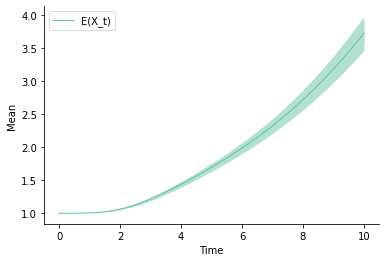

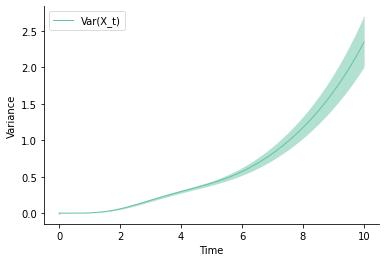

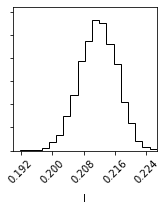

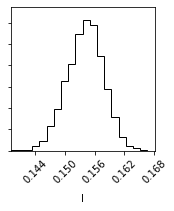

In [29]:
me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_plot(est_res[1])
me.plots.est_corner_plot(est_res[0])

##### tests for simulations

In [21]:
net = me.Network('net_div_l15')
net.structure([{'start': 'X_t', 'end': 'X_t',
                'rate_symbol': 'l',
                'type': 'S -> S + S', 'reaction_steps': 15}])

initial_values = {'X_t': 1}
theta_values = {'l': 0.23}
time_values = np.linspace(0.0, 10.0, endpoint=True, num=11)
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
sim_res_mom = sim.simulate('moments', initial_values, theta_values, time_values, variables)

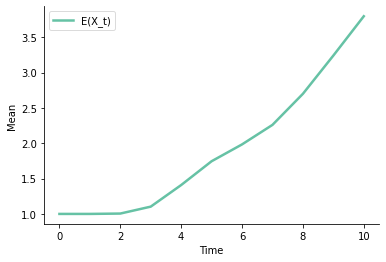

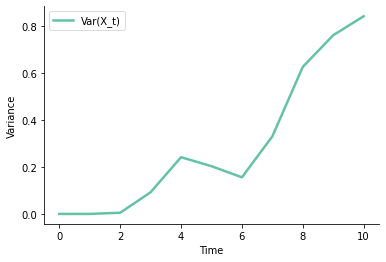

No handles with labels found to put in legend.


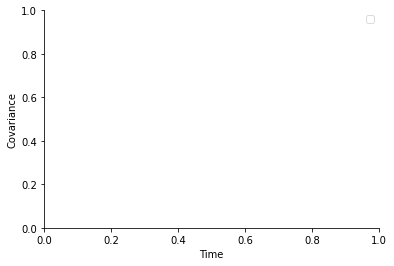

(array([[1.        , 1.0000036 , 1.00504242, 1.1029673 , 1.40858873,
         1.74539991, 1.9836416 , 2.2599425 , 2.69956532, 3.24078993,
         3.79706324]]),
 array([[0.00000000e+00, 3.59865514e-06, 5.01699099e-03, 9.23670549e-02,
         2.42073295e-01, 2.03605526e-01, 1.56235900e-01, 3.31027260e-01,
         6.27340021e-01, 7.62571027e-01, 8.43506503e-01]]),
 array([], shape=(0, 11), dtype=float64))

In [22]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)
sim.sim_moments_res

In [46]:
net = me.Network('net_div_l15')
net.structure([{'start': 'X_t', 'end': 'X_t',
                'rate_symbol': 'l',
                'type': 'S -> S + S', 'reaction_steps': 15}])

initial_values = {'X_t': 1}
theta_values = {'l': 0.23}
time_values = np.linspace(0.0, 10.0, endpoint=True, num=11)
variables = {'X_t': ('X_t', )}

num_iter = 100000
sim = me.Simulation(net)
res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [49]:
np.mean(sims, axis=0)

array([[1.     , 1.     , 1.00493, 1.10301, 1.40927, 1.74484, 1.98433,
        2.26114, 2.69884, 3.2382 , 3.79592]])

In [50]:
np.var(sims, axis=0, ddof=1)

array([[0.        , 0.        , 0.00490574, 0.09239986, 0.24225049,
        0.20399541, 0.15758603, 0.33282923, 0.62928895, 0.76288839,
        0.8444798 ]])

In [2]:

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_1')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)

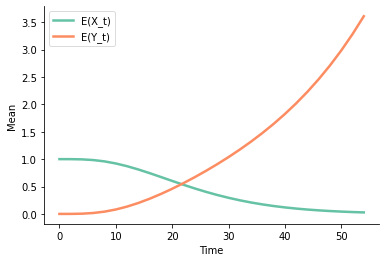

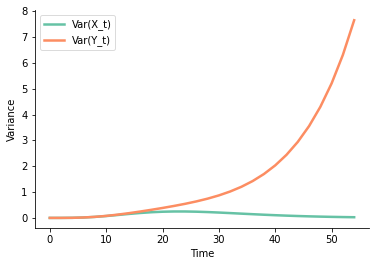

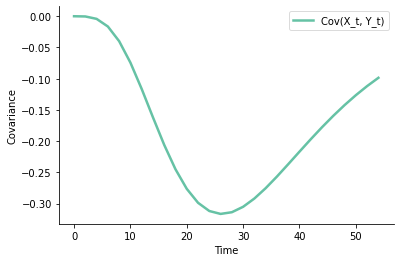

(array([[1.00000000e+00, 9.99661300e-01, 9.95786822e-01, 9.83366954e-01,
         9.58874286e-01, 9.21186515e-01, 8.71262892e-01, 8.11430693e-01,
         7.44676766e-01, 6.74094967e-01, 6.02519716e-01, 5.32323178e-01,
         4.65336116e-01, 4.02852123e-01, 3.45681548e-01, 2.94229914e-01,
         2.48583556e-01, 2.08591717e-01, 1.73939147e-01, 1.44206591e-01,
         1.18918774e-01, 9.75807212e-02, 7.97039295e-02, 6.48240663e-02,
         5.25120773e-02, 4.23801158e-02, 3.40838378e-02, 2.73219929e-02],
        [0.00000000e+00, 3.38772857e-04, 4.22009262e-03, 1.67215423e-02,
         4.16241791e-02, 8.06083680e-02, 1.33617836e-01, 1.99525682e-01,
         2.76739218e-01, 3.63634007e-01, 4.58818192e-01, 5.61265730e-01,
         6.70361616e-01, 7.85894491e-01, 9.08021977e-01, 1.03722529e+00,
         1.17426313e+00, 1.32013046e+00, 1.47602480e+00, 1.64332093e+00,
         1.82355402e+00, 2.01841042e+00, 2.22972532e+00, 2.45948640e+00,
         2.70984247e+00, 2.98311663e+00, 3.2818230

In [5]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)
sim.sim_moments_res

In [11]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

num_iter = 100000
sim = me.Simulation(net)
res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [12]:
np.mean(sims, axis=0)

array([[1.00000e+00, 9.99530e-01, 9.95480e-01, 9.83160e-01, 9.58880e-01,
        9.21070e-01, 8.71110e-01, 8.11450e-01, 7.47190e-01, 6.77130e-01,
        6.04910e-01, 5.35250e-01, 4.67990e-01, 4.04650e-01, 3.47950e-01,
        2.96460e-01, 2.51030e-01, 2.11430e-01, 1.75970e-01, 1.45980e-01,
        1.21450e-01, 9.95900e-02, 8.10600e-02, 6.65400e-02, 5.43100e-02,
        4.37800e-02, 3.51900e-02, 2.80700e-02],
       [0.00000e+00, 4.70000e-04, 4.53000e-03, 1.69600e-02, 4.16900e-02,
        8.06800e-02, 1.33540e-01, 1.99480e-01, 2.74680e-01, 3.61030e-01,
        4.56120e-01, 5.58050e-01, 6.67250e-01, 7.82160e-01, 9.04820e-01,
        1.03354e+00, 1.16850e+00, 1.31146e+00, 1.46749e+00, 1.63472e+00,
        1.81542e+00, 2.00863e+00, 2.21956e+00, 2.44913e+00, 2.69783e+00,
        2.97141e+00, 3.26897e+00, 3.59363e+00]])

In [13]:
np.var(sims, axis=0, ddof=1)

array([[0.00000000e+00, 4.69783798e-04, 4.49961460e-03, 1.65565800e-02,
        3.94295399e-02, 7.27007821e-02, 1.12278491e-01, 1.53000428e-01,
        1.88898993e-01, 2.18627149e-01, 2.38996282e-01, 2.48759925e-01,
        2.48977850e-01, 2.40910787e-01, 2.26883066e-01, 2.08573554e-01,
        1.88015819e-01, 1.66729022e-01, 1.45006009e-01, 1.24671086e-01,
        1.06700965e-01, 8.96727286e-02, 7.44900213e-02, 6.21130495e-02,
        5.13609375e-02, 4.18637302e-02, 3.39520034e-02, 2.72823479e-02],
       [0.00000000e+00, 4.69783798e-04, 4.52952440e-03, 1.69125275e-02,
        4.10923548e-02, 7.76715143e-02, 1.25248321e-01, 1.82409554e-01,
        2.45593354e-01, 3.13370473e-01, 3.83918385e-01, 4.61594813e-01,
        5.45852896e-01, 6.37712112e-01, 7.49148259e-01, 8.74603814e-01,
        1.02163797e+00, 1.20002467e+00, 1.41959730e+00, 1.69802750e+00,
        2.03763060e+00, 2.43713989e+00, 2.93098272e+00, 3.55528780e+00,
        4.30866638e+00, 5.20978471e+00, 6.29272807e+00, 7.63592

In [14]:
np.array([np.cov(sims[:, 0, i], sims[:, 1, i], ddof=1)[1,0] for i in range(sims.shape[2])])

array([ 0.        , -0.00046978, -0.00450957, -0.01667456, -0.03997611,
       -0.07431267, -0.11632919, -0.16186966, -0.2052402 , -0.24446669,
       -0.27591431, -0.29869925, -0.31226945, -0.31650421, -0.31483527,
       -0.30640633, -0.29333149, -0.27728476, -0.2582368 , -0.23863881,
       -0.22048496, -0.20004146, -0.17991933, -0.16296674, -0.14652061,
       -0.13008963, -0.1150362 , -0.1008742 ])

In [18]:
def gill_indep_test_1(initial_state, time_values, d, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 7, time_values.shape[0]))

    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(7)
        cell_state = copy.deepcopy(initial_state)

#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)

        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                4.0 * d * cell_state[0], # d from Xcentric to X0
                4.0 * d * cell_state[1], # d from X0 to X1
                4.0 * d * cell_state[2], # d from X1 to X2
                4.0 * d * cell_state[3], # d from X2 to Ycentric
                3.0 * l * cell_state[4], # l from Ycentric to Y0
                3.0 * l * cell_state[5], # l from Y0 to Y1
                3.0 * l * cell_state[6], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)

#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current)
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,7))

#             print('res: ', res)

            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)

#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[4] += +1.0

            # division
            elif reac_rand==4:
                cell_state[4] += -1.0
                cell_state[5] += +1.0
            elif reac_rand==5:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==6:
                cell_state[6] += -1.0
                cell_state[4] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt

#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')

    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (4,5,6), :], axis=1)
    return res_obs

In [28]:
# order of the variables of the hidden layer
# X centric, X diff 0, X diff 1, X diff 2, Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d = 0.04
l = 0.06
num_iter = 100000

# save result as external simulation results
sims = gill_indep_test_1(initial_values, time_values, d, l, num_iter)

In [29]:
np.mean(sims, axis=0)

array([[1.00000e+00, 9.99650e-01, 9.95750e-01, 9.83370e-01, 9.58770e-01,
        9.20350e-01, 8.71090e-01, 8.11320e-01, 7.44530e-01, 6.74820e-01,
        6.02140e-01, 5.32020e-01, 4.65220e-01, 4.02320e-01, 3.45360e-01,
        2.94870e-01, 2.48850e-01, 2.09330e-01, 1.73650e-01, 1.43200e-01,
        1.18660e-01, 9.80300e-02, 8.02000e-02, 6.51500e-02, 5.28200e-02,
        4.25100e-02, 3.41700e-02, 2.79700e-02],
       [0.00000e+00, 3.50000e-04, 4.25000e-03, 1.67500e-02, 4.18300e-02,
        8.15000e-02, 1.33830e-01, 1.99760e-01, 2.77570e-01, 3.63560e-01,
        4.59590e-01, 5.62800e-01, 6.71670e-01, 7.88180e-01, 9.11180e-01,
        1.04066e+00, 1.17833e+00, 1.32300e+00, 1.48030e+00, 1.64735e+00,
        1.82632e+00, 2.01993e+00, 2.22942e+00, 2.46117e+00, 2.71453e+00,
        2.98650e+00, 3.28881e+00, 3.61411e+00]])

In [30]:
np.var(sims, axis=0, ddof=1)

array([[0.00000000e+00, 3.49880999e-04, 4.23197982e-03, 1.63536066e-02,
        3.95304824e-02, 7.33066106e-02, 1.12293335e-01, 1.53081388e-01,
        1.90206981e-01, 2.19440162e-01, 2.39569816e-01, 2.48977209e-01,
        2.48792840e-01, 2.40461022e-01, 2.26088731e-01, 2.07923762e-01,
        1.86925547e-01, 1.65512606e-01, 1.43497112e-01, 1.22694987e-01,
        1.04580850e-01, 8.84210033e-02, 7.37686977e-02, 6.09060866e-02,
        5.00305479e-02, 4.07033069e-02, 3.30027411e-02, 2.71879510e-02],
       [0.00000000e+00, 3.49880999e-04, 4.23197982e-03, 1.67096046e-02,
        4.13006641e-02, 7.86585366e-02, 1.26000791e-01, 1.82957772e-01,
        2.47507370e-01, 3.14787274e-01, 3.85850890e-01, 4.63920799e-01,
        5.49894910e-01, 6.42418712e-01, 7.52358531e-01, 8.80135566e-01,
        1.03315874e+00, 1.21644316e+00, 1.44056632e+00, 1.71260510e+00,
        2.04427570e+00, 2.45859738e+00, 2.95611602e+00, 3.58072804e+00,
        4.35016038e+00, 5.24087016e+00, 6.38366262e+00, 7.75105

In [31]:
np.array([np.cov(sims[:, 0, i], sims[:, 1, i], ddof=1)[1,0] for i in range(sims.shape[2])])

array([ 0.        , -0.00034988, -0.00423198, -0.01647161, -0.04010575,
       -0.07500928, -0.11657914, -0.1620709 , -0.20666126, -0.24534001,
       -0.27674029, -0.29942385, -0.31247744, -0.31710375, -0.31468827,
       -0.30686248, -0.29323035, -0.27694636, -0.25705667, -0.23590288,
       -0.2167133 , -0.19801572, -0.17880127, -0.16034683, -0.14338291,
       -0.12695738, -0.11237976, -0.10108767])

In [33]:
# current implementation way of two parallel channels
# (this should be replaced by multichannel nets at some point)
net = me.Network('net_par2')
net.structure([
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0}
theta_values = {'l': 0.06, 'd4': 0.06, 'd2': 0.08}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
sim_res_mom = sim.simulate('moments', initial_values, theta_values, time_values, variables)

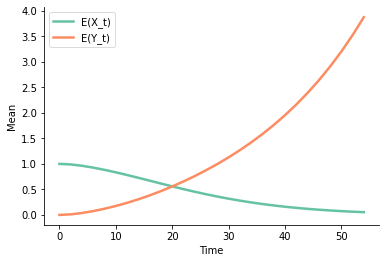

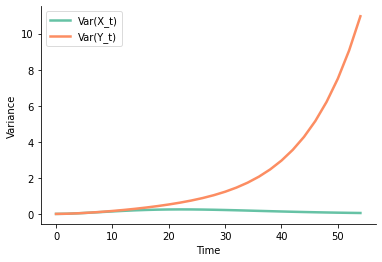

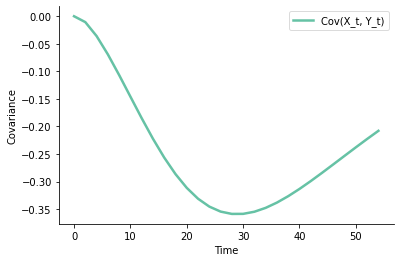

(array([[1.        , 0.9892332 , 0.9628573 , 0.92641326, 0.88291527,
         0.83425905, 0.78189005, 0.72708038, 0.671013  , 0.61478239,
         0.55936821, 0.50560865, 0.45418393, 0.40561213, 0.36025565,
         0.31833546, 0.27994993, 0.24509568, 0.21368863, 0.18558362,
         0.16059206, 0.13849701, 0.11906575, 0.10205975, 0.08724246,
         0.07438504, 0.06327037, 0.05369577],
        [0.        , 0.01077441, 0.03733088, 0.07470416, 0.1208133 ,
         0.1748674 , 0.23655813, 0.30571417, 0.38219578, 0.46589589,
         0.55677665, 0.6549082 , 0.76049766, 0.8739066 , 0.99565908,
         1.12644342, 1.2671107 , 1.41867221, 1.58229732, 1.75931293,
         1.95120503, 2.15962273, 2.38638491, 2.63348958, 2.90312602,
         3.1976896 , 3.51979935, 3.87231827]]),
 array([[0.00000000e+00, 1.06508802e-02, 3.57631223e-02, 6.81717355e-02,
         1.03375893e-01, 1.38270887e-01, 1.70537997e-01, 1.98434501e-01,
         2.20754555e-01, 2.36825004e-01, 2.46475416e-01, 2.49968543e-0

In [35]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)
sim.sim_moments_res

In [41]:
net = me.Network('net_par2')
net.structure([
    {'start': 'S_t', 'end': 'P1_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},
    {'start': 'P1_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': int(4/2)},

    {'start': 'S_t', 'end': 'P2_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},
    {'start': 'P2_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': int(2/2)},

    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'S_t': 1, 'Y_t': 0, 'P1_t': 0, 'P2_t': 0}
theta_values = {'l': 0.06, 'd4': 0.06, 'd2': 0.08}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('S_t', 'P1_t', 'P2_t'), 'Y_t': ('Y_t', )}

num_iter = 100000
sim = me.Simulation(net)
res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [42]:
np.mean(sims, axis=0)

array([[1.     , 0.98917, 0.96263, 0.92617, 0.88359, 0.83522, 0.78319,
        0.72803, 0.67007, 0.61486, 0.55918, 0.50559, 0.45419, 0.40623,
        0.36079, 0.31911, 0.28094, 0.24543, 0.21371, 0.18521, 0.15994,
        0.1384 , 0.11941, 0.10197, 0.08769, 0.07461, 0.06377, 0.05413],
       [0.     , 0.01084, 0.03752, 0.07478, 0.12034, 0.17392, 0.23561,
        0.30488, 0.38269, 0.46588, 0.55629, 0.65378, 0.75971, 0.87289,
        0.99413, 1.1231 , 1.26451, 1.41578, 1.58057, 1.75827, 1.94899,
        2.15551, 2.38079, 2.62727, 2.89559, 3.19119, 3.51406, 3.86838]])

In [43]:
np.var(sims, axis=0, ddof=1)

array([[0.00000000e+00, 1.07128182e-02, 3.59738428e-02, 6.83798149e-02,
        1.02859740e-01, 1.37628928e-01, 1.69805122e-01, 1.98004299e-01,
        2.21078406e-01, 2.36809548e-01, 2.46500193e-01, 2.49971252e-01,
        2.47903923e-01, 2.41209599e-01, 2.30622882e-01, 2.17280981e-01,
        2.02014737e-01, 1.85195967e-01, 1.68039716e-01, 1.50908765e-01,
        1.34360540e-01, 1.19246632e-01, 1.05152303e-01, 9.15730348e-02,
        8.00012639e-02, 6.90440383e-02, 5.97039841e-02, 5.12004551e-02],
       [0.00000000e+00, 1.07426018e-02, 3.64126137e-02, 7.11286629e-02,
        1.13819423e-01, 1.62513459e-01, 2.19480123e-01, 2.82591012e-01,
        3.53281897e-01, 4.33220158e-01, 5.20336639e-01, 6.22157933e-01,
        7.40698123e-01, 8.81641864e-01, 1.04132596e+00, 1.22763867e+00,
        1.45927905e+00, 1.72986429e+00, 2.05994907e+00, 2.46300124e+00,
        2.94169740e+00, 3.53208196e+00, 4.25209150e+00, 5.10897344e+00,
        6.18169037e+00, 7.47975118e+00, 9.04491277e+00, 1.09330

In [44]:
np.array([np.cov(sims[:, 0, i], sims[:, 1, i], ddof=1)[1,0]
                                        for i in range(sims.shape[2])])

array([ 0.        , -0.01072271, -0.03611824, -0.06925969, -0.10633228,
       -0.14526292, -0.18452924, -0.22196401, -0.25643165, -0.28645384,
       -0.31106935, -0.33054794, -0.34505614, -0.35459765, -0.35867575,
       -0.35839602, -0.35525499, -0.34747836, -0.33778699, -0.32565244,
       -0.31172458, -0.29832557, -0.28429298, -0.2679054 , -0.25391683,
       -0.23809707, -0.22409385, -0.2093975 ])

In [45]:
def gill_indep_test_2(initial_state, time_values, d4, d2, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 8, time_values.shape[0]))
    
    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(8)
        cell_state = copy.deepcopy(initial_state)
        
#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)
        
        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                # NOTE: division by 2 in the diff channels is only due to
                # current workaround for multigraphs (with P intermediate nodes)
                
                # differentiation d4 channel
                4.0/2 * d4 * cell_state[0], # d from Xcentric to X0
                4.0/2 * d4 * cell_state[1], # d from X0 to X1
                4.0/2 * d4 * cell_state[2], # d from X1 to X2
                4.0/2 * d4 * cell_state[3], # d from X2 to Ycentric
                
                # differentiation d2 channel
                2.0/2 * d2 * cell_state[0], # d from Xcentric to X0
                2.0/2 * d2 * cell_state[4], # d from X0 to X1
                
                # division
                3.0 * l * cell_state[5], # l from Ycentric to Y0
                3.0 * l * cell_state[6], # l from Y0 to Y1
                3.0 * l * cell_state[7], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)
            
#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current) 
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,8))
            
#             print('res: ', res)
            
            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)
            
#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation d4 channel
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[5] += +1.0
                
            # differentiation d2 channel
            elif reac_rand==4:
                cell_state[0] += -1.0
                cell_state[4] += +1.0
            elif reac_rand==5:
                cell_state[4] += -1.0
                cell_state[5] += +1.0 

            # division
            elif reac_rand==6:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==7:
                cell_state[6] += -1.0
                cell_state[7] += +1.0
            elif reac_rand==8:
                cell_state[7] += -1.0
                cell_state[5] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt
            
#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')
    
    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3,4), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (5,6,7), :], axis=1)
    return res_obs

In [53]:
# order of the variables of the hidden layer
# 0,1,2,3,4: X centric, X diff4 0, X diff4 1, X diff4 2, X diff2 0, 
# 5,6,7: Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d4 = 0.06
d2 = 0.08
l = 0.06
num_iter = 100000
print(time_values)

# save result as external simulation results
sims = gill_indep_test_2(initial_values, time_values, d4, d2, l, num_iter)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


In [54]:
np.mean(sims, axis=0)

array([[1.     , 0.98943, 0.9631 , 0.92714, 0.88312, 0.83479, 0.78267,
        0.72796, 0.67315, 0.61471, 0.5597 , 0.50621, 0.45568, 0.40713,
        0.36222, 0.31951, 0.28133, 0.24632, 0.21476, 0.18607, 0.161  ,
        0.13809, 0.11862, 0.10166, 0.08677, 0.07401, 0.06294, 0.05356],
       [0.     , 0.0106 , 0.0371 , 0.07394, 0.12049, 0.17407, 0.23557,
        0.30505, 0.3802 , 0.46596, 0.55587, 0.65428, 0.75853, 0.87224,
        0.9934 , 1.12505, 1.26381, 1.41601, 1.58016, 1.7573 , 1.94785,
        2.15775, 2.38401, 2.62926, 2.89853, 3.19214, 3.51472, 3.86759]])

In [55]:
np.var(sims, axis=0, ddof=1)

array([[0.00000000e+00, 1.04583797e-02, 3.55387454e-02, 6.75520959e-02,
        1.03220098e-01, 1.37917035e-01, 1.70099372e-01, 1.98036219e-01,
        2.20021278e-01, 2.36843984e-01, 2.46438374e-01, 2.49963936e-01,
        2.48038218e-01, 2.41377577e-01, 2.31018982e-01, 2.17425534e-01,
        2.02185453e-01, 1.85648314e-01, 1.68639829e-01, 1.51449470e-01,
        1.35080351e-01, 1.19022342e-01, 1.04550341e-01, 9.13261577e-02,
        7.92417595e-02, 6.85332052e-02, 5.89791462e-02, 5.06918333e-02],
       [0.00000000e+00, 1.05477455e-02, 3.61239512e-02, 7.06735831e-02,
        1.13273293e-01, 1.62051256e-01, 2.18438959e-01, 2.83377331e-01,
        3.53771498e-01, 4.34305621e-01, 5.23163775e-01, 6.26783949e-01,
        7.43369673e-01, 8.84046223e-01, 1.04654691e+00, 1.23784488e+00,
        1.45946888e+00, 1.73526303e+00, 2.06791505e+00, 2.48022151e+00,
        2.96636004e+00, 3.56040054e+00, 4.26600898e+00, 5.13526321e+00,
        6.18845572e+00, 7.46423686e+00, 9.04141374e+00, 1.09308

In [56]:
np.array([np.cov(sims[:, 0, i], sims[:, 1, i], ddof=1)[1,0] for i in range(sims.shape[2])])

array([ 0.        , -0.01048806, -0.03573137, -0.06855342, -0.10640819,
       -0.14531335, -0.18437542, -0.22206642, -0.25593419, -0.28643314,
       -0.31112355, -0.33120639, -0.34565041, -0.35511862, -0.35983295,
       -0.35946832, -0.35555122, -0.34879507, -0.33935856, -0.32698408,
       -0.31360699, -0.29796668, -0.28279409, -0.26729324, -0.25150796,
       -0.23625264, -0.22121869, -0.20715019])

In [61]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'Y_t': ('Y_t', )} # {'X_t': ('X_t', )} # {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)


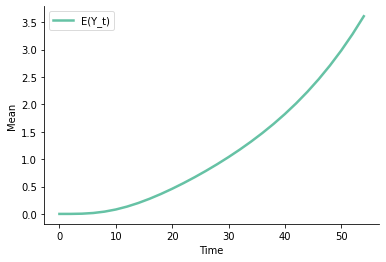

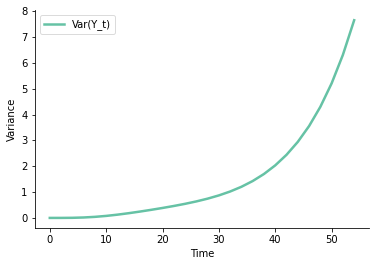

No handles with labels found to put in legend.


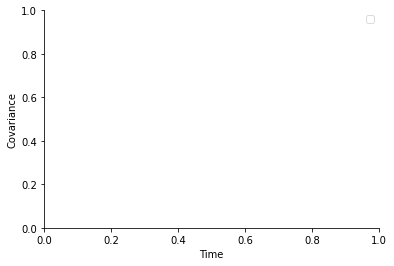

In [62]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

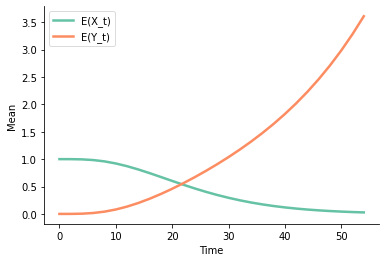

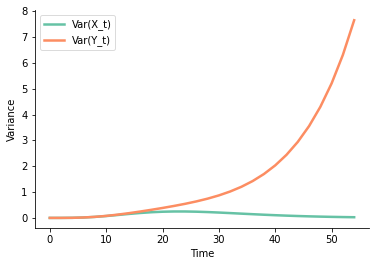

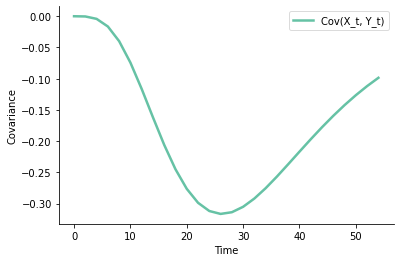

In [58]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

In [81]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)

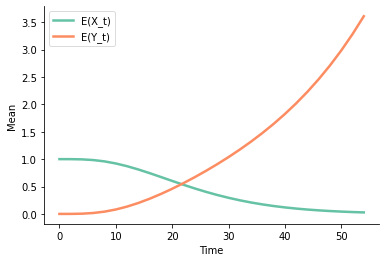

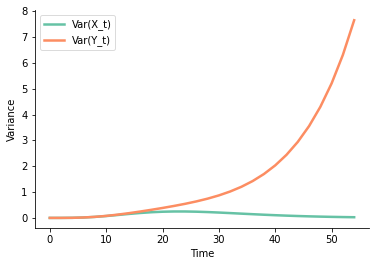

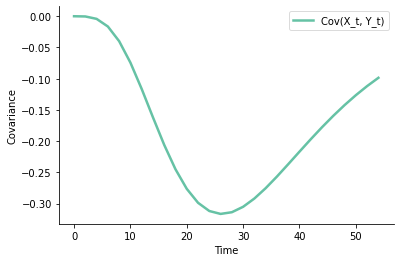

In [82]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

In [83]:
# expected mean for T = X + Y simulation variable
mean_exp = np.sum(sim.sim_moments_res[0], axis=0).reshape(1, 28)

In [84]:
# expected variance for T = X + Y simulation variable
# as Var(T) = Var(X) + Var(Y) + 2 Cov(X, Y)
var_exp = np.sum(sim.sim_moments_res[1], axis=0).reshape(1, 28) + 2.0 * sim.sim_moments_res[2]

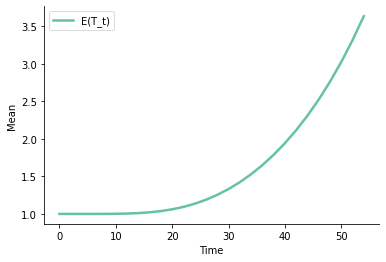

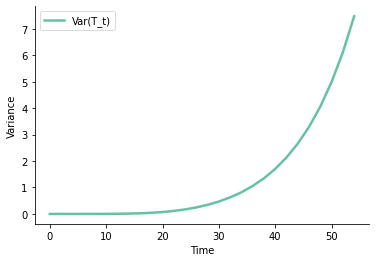

No handles with labels found to put in legend.


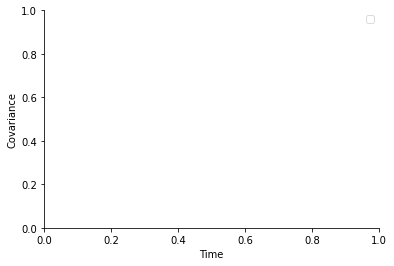

(array([[1.        , 1.00000007, 1.00000691, 1.0000885 , 1.00049847,
         1.00179488, 1.00488073, 1.01095637, 1.02141598, 1.03772897,
         1.06133791, 1.09358891, 1.13569773, 1.18874661, 1.25370353,
         1.3314552 , 1.42284668, 1.52872218, 1.64996395, 1.78752752,
         1.9424728 , 2.11599114, 2.30942925, 2.52431046, 2.76235455,
         3.02549675, 3.31590684, 3.6360089 ]]),
 array([[0.00000000e+00, 7.24812210e-08, 6.92827298e-06, 8.90767729e-05,
         5.05956224e-04, 1.84536272e-03, 5.10617417e-03, 1.17151055e-02,
         2.34956851e-02, 4.26144757e-02, 7.15279595e-02, 1.12949855e-01,
         1.69853707e-01, 2.45519549e-01, 3.43627603e-01, 4.68397723e-01,
         6.24771534e-01, 8.18634751e-01, 1.05707948e+00, 1.34870928e+00,
         1.70399356e+00, 2.13568124e+00, 2.65928936e+00, 3.29367908e+00,
         4.06174456e+00, 4.99124079e+00, 6.11577409e+00, 7.47599908e+00]]),
 array([], shape=(0, 28), dtype=float64))

In [85]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'T_t': ('X_t', 'Y_t')}

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)
sim.sim_moments_res

In [88]:
print(mean_exp==sim.sim_moments_res[0])
print(var_exp==sim.sim_moments_res[1])

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]


In [6]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables,
                    moment_mean_only=True)

In [7]:
sim.sim_moments_res

(array([[1.00000000e+00, 9.99661300e-01, 9.95786822e-01, 9.83366954e-01,
         9.58874286e-01, 9.21186515e-01, 8.71262892e-01, 8.11430693e-01,
         7.44676766e-01, 6.74094967e-01, 6.02519716e-01, 5.32323178e-01,
         4.65336116e-01, 4.02852123e-01, 3.45681548e-01, 2.94229914e-01,
         2.48583556e-01, 2.08591718e-01, 1.73939145e-01, 1.44206584e-01,
         1.18918767e-01, 9.75807233e-02, 7.97039344e-02, 6.48240759e-02,
         5.25120809e-02, 4.23801201e-02, 3.40838418e-02, 2.73219966e-02],
        [0.00000000e+00, 3.38772857e-04, 4.22009262e-03, 1.67215423e-02,
         4.16241791e-02, 8.06083680e-02, 1.33617836e-01, 1.99525682e-01,
         2.76739218e-01, 3.63634007e-01, 4.58818192e-01, 5.61265730e-01,
         6.70361616e-01, 7.85894491e-01, 9.08021977e-01, 1.03722529e+00,
         1.17426313e+00, 1.32013046e+00, 1.47602480e+00, 1.64332093e+00,
         1.82355402e+00, 2.01841041e+00, 2.22972531e+00, 2.45948638e+00,
         2.70984246e+00, 2.98311662e+00, 3.2818229

In [8]:
net = me.Network('net_min')
net.structure([
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ])

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

simfull = me.Simulation(net)
res = simfull.simulate('moments', initial_values, theta_values, time_values, variables)

In [9]:
simfull.sim_moments_res

(array([[1.00000000e+00, 9.99661300e-01, 9.95786822e-01, 9.83366954e-01,
         9.58874286e-01, 9.21186515e-01, 8.71262892e-01, 8.11430693e-01,
         7.44676766e-01, 6.74094967e-01, 6.02519716e-01, 5.32323178e-01,
         4.65336116e-01, 4.02852123e-01, 3.45681548e-01, 2.94229914e-01,
         2.48583556e-01, 2.08591717e-01, 1.73939147e-01, 1.44206591e-01,
         1.18918774e-01, 9.75807212e-02, 7.97039295e-02, 6.48240663e-02,
         5.25120773e-02, 4.23801158e-02, 3.40838378e-02, 2.73219929e-02],
        [0.00000000e+00, 3.38772857e-04, 4.22009262e-03, 1.67215423e-02,
         4.16241791e-02, 8.06083680e-02, 1.33617836e-01, 1.99525682e-01,
         2.76739218e-01, 3.63634007e-01, 4.58818192e-01, 5.61265730e-01,
         6.70361616e-01, 7.85894491e-01, 9.08021977e-01, 1.03722529e+00,
         1.17426313e+00, 1.32013046e+00, 1.47602480e+00, 1.64332093e+00,
         1.82355402e+00, 2.01841042e+00, 2.22972532e+00, 2.45948640e+00,
         2.70984247e+00, 2.98311663e+00, 3.2818230

In [14]:
sim.sim_moments_res[0] - simfull.sim_moments_res[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -4.61275296e-10,  5.19682103e-10,
        -1.94837022e-09, -6.95227159e-09, -7.71557646e-09,
         2.11274140e-09,  4.87620611e-09,  9.55842813e-09,
         3.59784711e-09,  4.32134851e-09,  3.92674836e-09,
         3.64677257e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.27982069e-10, -5.97419225e-10,
        -1.87678761e-11,  3.85062426e-10, -2.22159291e-09,
        -6.42256648e-09, -8.82

In [13]:
np.allclose(sim.sim_moments_res[0], simfull.sim_moments_res[0])

True

In [18]:
not False

True

In [2]:
net = me.Network('net_div_l15')
net.structure([{'start': 'X_t', 'end': 'X_t',
                'rate_symbol': 'l',
                'type': 'S -> S + S', 'reaction_steps': 15}])

initial_values = {'X_t': 1}
theta_values = {'l': 0.23}
time_values = np.linspace(0.0, 10.0, endpoint=True, num=100)
variables = {'X_t': ('X_t', ), 'W_t': ('X_t', )}

sim = me.Simulation(net)

In [20]:
initial_values = {'X_t': 1}
theta_values = {'l': 0.23}
variables = {'X_t': ('X_t', )}
time_values = np.linspace(0.0, 10.0, endpoint=True, num=100)
sim_res_mom = sim.simulate('moments', variables, initial_values, theta_values, time_values)

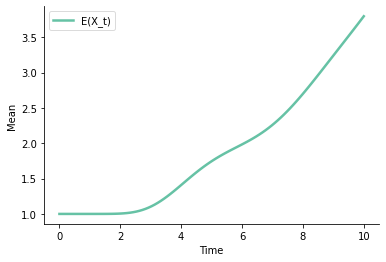

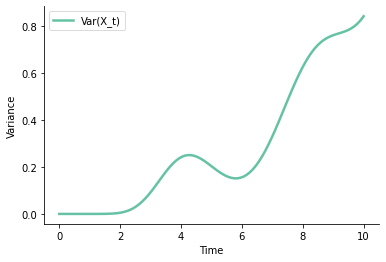

No handles with labels found to put in legend.


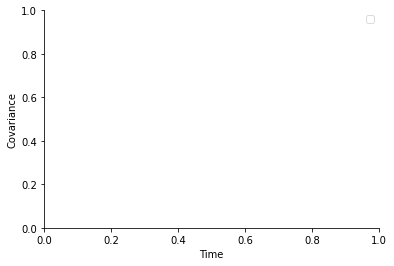

In [21]:
me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

##### fit and sim mean only runs

In [4]:
### create data from 5-steps model
t = [
    {'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 5}
    ]

net = me.Network('net_div_g5')
net.structure(t)

num_iter = 100
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

do stuff


In [5]:
data = me.Data('data_test_select_models')
data.load(['X_t',], time_values, sims, bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with known values (from a num_iter=100 simulation)
data.data_mean = np.array([[[1.         , 3.73      ]],
                           [[0.01       , 0.15406761]]])
data.data_variance = np.array([[[0.         , 2.36070707]],
                               [[0.01       , 0.32208202]]])

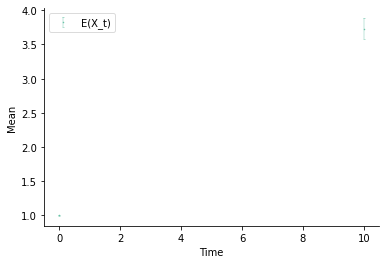

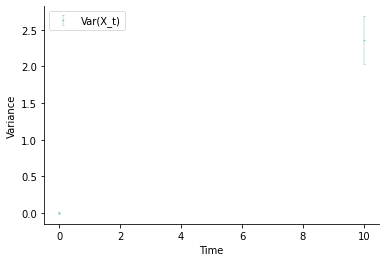

In [6]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)

In [7]:
### define models for selection
net2 = me.Network('net_div_g2')
net2.structure([{'start': 'X_t', 'end': 'X_t',
             'rate_symbol': 'l',
             'type': 'S -> S + S',
             'reaction_steps': 2}])

net5 = me.Network('net_div_g5')
net5.structure([{'start': 'X_t', 'end': 'X_t',
             'rate_symbol': 'l',
             'type': 'S -> S + S',
             'reaction_steps': 5}])

net15 = me.Network('net_div_g15')
net15.structure([{'start': 'X_t', 'end': 'X_t',
              'rate_symbol': 'l',
              'type': 'S -> S + S',
              'reaction_steps': 15}])

# important note: theta_bounds are reduced here to
# prevent odeint warning at high steps
networks = [net2, net5, net15]
variables = [{'X_t': ('X_t', )}]*3
initial_values = [{'X_t': 1.0}]*3
theta_bounds = [{'l': (0.0, 0.5)}]*3

In [7]:
### run selection (sequentially)

est_res = me.selection.select_models(networks, variables, initial_values,
                                            theta_bounds, data, parallel=False)
print([est.bay_est_log_evidence for est in est_res])
print(me.selection.compute_model_probabilities(est_res))


[-10.630947091836521, 4.733753113391216, -5.883954044837904]
[2.12414795e-07 9.99975309e-01 2.44780968e-05]


In [26]:
est_res[0].net_simulation.sim_moments.moment_eqs

['-2.0*m[0]*theta[0] + 4.0*m[1]*theta[0]',
 '2.0*m[0]*theta[0] - 2.0*m[1]*theta[0]',
 '4.0*m[1]*theta[0] - 4.0*m[2]*theta[0] + 8.0*m[3]*theta[0]',
 '2.0*m[2]*theta[0] - 4.0*m[3]*theta[0] + 4.0*m[4]*theta[0]',
 '4.0*m[3]*theta[0] - 4.0*m[4]*theta[0]']

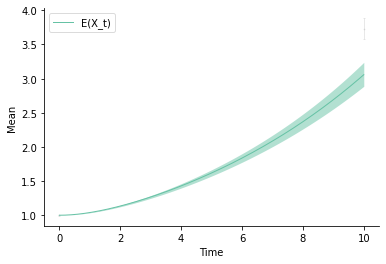

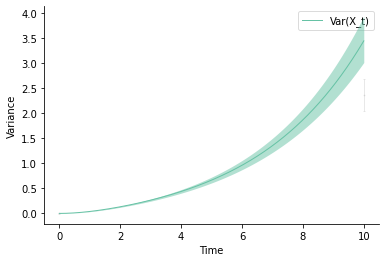

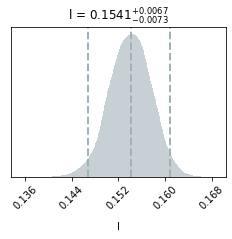

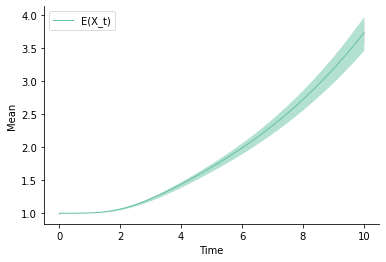

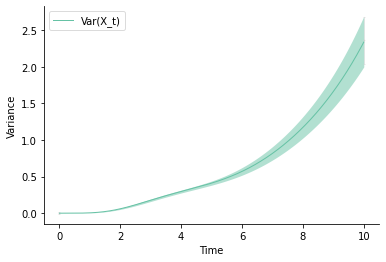

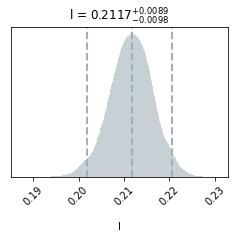

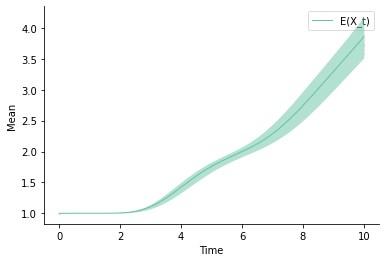

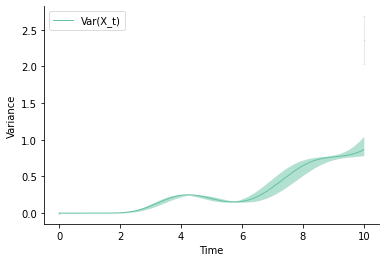

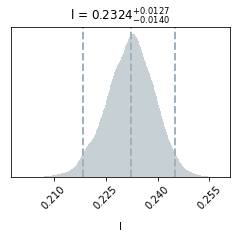

In [17]:
me.plots.est_bestfit_mean_plot(est_res[0])
me.plots.est_bestfit_variance_plot(est_res[0])
me.plots.est_corner_kernel_plot(est_res[0])

me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_kernel_plot(est_res[1])

me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])

In [9]:
import time
tstart = time.time()
for __ in range(10):
    est_res_all_mean = me.selection.select_models(networks, variables, initial_values,
                                                theta_bounds, data, 
                                                sim_mean_only=True, fit_mean_only=True,
                                                parallel=False)
    print([est.bay_est_log_evidence for est in est_res_all_mean])
    print([est.bay_est_log_likelihood_max for est in est_res_all_mean])
    print([est.bay_est_bayesian_information_criterion for est in est_res_all_mean])
    print([est.bay_est_params_cred for est in est_res_all_mean])
    print(me.selection.compute_model_probabilities(est_res_all_mean))
    print(me.selection.compute_model_bayes_factors(est_res_all_mean))
print(time.time()-tstart)


[0.9419435322851446, 1.0106982945064, 1.1012240890675635]
[4.637656866490975, 4.63765686651381, 4.637656866427406]
[-8.582166552422004, -8.582166552467674, -8.582166552294867]
[((0.17767525971322726, 0.16766484301297668, 0.1871859065530188),), ((0.2116378072993456, 0.19980784768361473, 0.22221378166000505),), ((0.22706308238730954, 0.21426688997969887, 0.23898897505750633),)]
[0.30827657 0.33021769 0.36150573]
[1.1726669  1.09474975 1.        ]



[0.9566246018872815, 1.0030070861382694, 1.185808337623029]
[4.637656866313304, 4.63765686645764, 4.637656866472604]
[-8.582166552066663, -8.582166552355334, -8.582166552385262]
[((0.17783574075135636, 0.16745234255033054, 0.18709129910629485),), ((0.21159566312843459, 0.20025740650972587, 0.22225069777450657),), ((0.22685131261479294, 0.2148889188053539, 0.23873886327930333),)]
[0.30256746 0.31693184 0.38050069]
[1.25757308 1.20057577 1.        ]



[0.9907574912748793, 1.047671927169712, 1.19272285522771]
[4.637656866511199, 4.637656866434893, 4.637656866503798]
[-8.582166552462452, -8.582166552309841, -8.582166552447651]
[((0.17772495817619227, 0.16792866692656294, 0.18716373871632497),), ((0.21147737507817208, 0.20013138837338232, 0.2221836017996362),), ((0.22712942097758385, 0.21459786012153031, 0.239019411969675),)]
[0.30465784 0.32250019 0.37284197]
[1.22380562 1.15609845 1.        ]



[0.9344626373613755, 1.0150202141481144, 1.1356276897852824]
[4.637656866478411, 4.637656866496112, 4.637656866472503]
[-8.582166552396876, -8.582166552432279, -8.582166552385061]
[((0.17765310186185357, 0.16737710709424608, 0.18699853276265388),), ((0.21152367704878855, 0.20017333735288512, 0.22195840272665873),), ((0.22739299020772027, 0.21494870304871327, 0.23871190646445717),)]
[0.30241467 0.32778462 0.3698007 ]
[1.22282659 1.12818199 1.        ]



[0.9957857383128643, 1.1147029967812334, 1.2813572453964095]
[4.637656866481246, 4.637656866487981, 4.637656866364033]
[-8.582166552402546, -8.582166552416016, -8.58216655216812]
[((0.17774890954479852, 0.16785378992605757, 0.18692744095053854),), ((0.2117422771562304, 0.20033115893162734, 0.221744778476685),), ((0.22700636347057088, 0.21483175457317827, 0.23850802940459553),)]
[0.28928498 0.32581494 0.38490009]
[1.33052221 1.18134574 1.        ]



[0.9224870435679013, 1.135816900454853, 1.2377276605741654]
[4.63765686651618, 4.637656866167647, 4.637656866000495]
[-8.582166552472415, -8.582166551775348, -8.582166551441045]
[((0.17770323548026393, 0.16762338985697867, 0.18722030610380444),), ((0.21148199985918062, 0.20004025740164794, 0.22246417034066013),), ((0.22726641468296005, 0.21508239943597135, 0.23893200778722384),)]
[0.27713253 0.34303267 0.37983481]
[1.37058906 1.10728465 1.        ]



[0.9894778490215606, 1.0941277563587202, 1.1494814071976407]
[4.6376568664946385, 4.637656866516615, 4.637656865509905]
[-8.582166552429332, -8.582166552473284, -8.582166550459865]
[((0.17774638376606106, 0.16741064926107696, 0.18714861450676257),), ((0.211685981167947, 0.20044959549495348, 0.2218134914679289),), ((0.2272913418178502, 0.21488828222344508, 0.23918800766586332),)]
[0.30452183 0.33811723 0.35736094]
[1.17351505 1.05691433 1.        ]



[0.9845703717052129, 1.2037659025849716, 1.1818061600496066]
[4.637656866397452, 4.63765686646518, 4.637656866516921]
[-8.582166552234959, -8.582166552370415, -8.582166552473897]
[((0.17786567511829948, 0.16774372529113826, 0.18716669314766138),), ((0.21176955766928585, 0.2003380716254387, 0.2220132491656906),), ((0.2267721834898168, 0.2144859118131004, 0.23877758912985064),)]
[0.28875813 0.35952545 0.35171642]
[1.2450747  1.         1.02220263]



[0.9512176652730777, 1.0724397747692442, 1.2583570008429867]
[4.637656866513331, 4.637656866516135, 4.637656866481746]
[-8.582166552466717, -8.582166552472325, -8.582166552403546]
[((0.17774477002988257, 0.16777800470913823, 0.186737513643131),), ((0.21140631049740677, 0.20034762799106276, 0.22201850676261048),), ((0.22699475212678594, 0.21520075443250175, 0.23875173560623902),)]
[0.28666388 0.32360786 0.38972826]
[1.35953039 1.20432257 1.        ]



[0.8883984291598804, 1.003479199497773, 1.1824954558159297]
[4.6376568665054085, 4.637656866400874, 4.63765686645308]
[-8.582166552450872, -8.582166552241803, -8.582166552346214]
[((0.17768763634149626, 0.16748127097311355, 0.18726644765855052),), ((0.21158086725786138, 0.20022479235379922, 0.22237544704503034),), ((0.22692686604795786, 0.21503615490679384, 0.2388629470323908),)]
[0.28869376 0.32390402 0.38740222]
[1.3419141  1.19604019 1.        ]
524.4394969940186


In [25]:
est_res_all_mean[0].net_simulation.sim_moments.moment_eqs

['-2.0*m[0]*theta[0] + 4.0*m[1]*theta[0]',
 '2.0*m[0]*theta[0] - 2.0*m[1]*theta[0]']

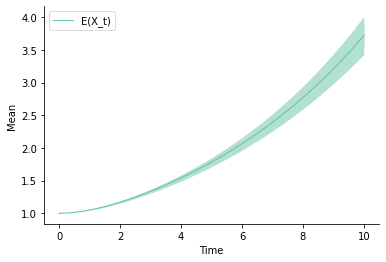

No handles with labels found to put in legend.


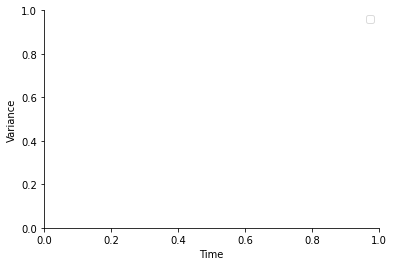

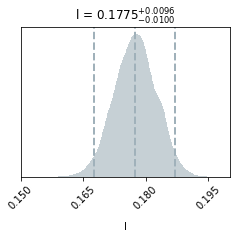

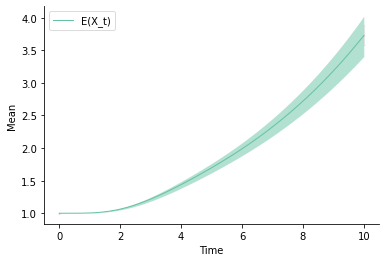

No handles with labels found to put in legend.


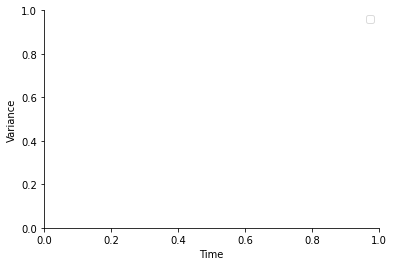

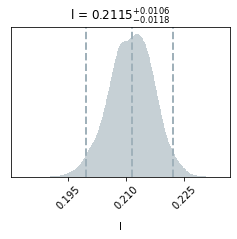

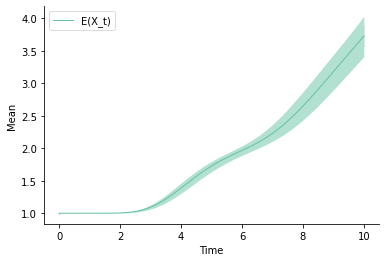

No handles with labels found to put in legend.


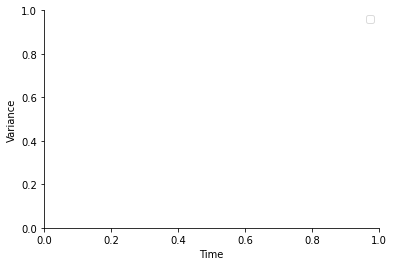

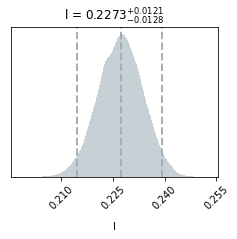

In [10]:
me.plots.est_bestfit_mean_plot(est_res_all_mean[0])
me.plots.est_bestfit_variance_plot(est_res_all_mean[0])
me.plots.est_corner_kernel_plot(est_res_all_mean[0])

me.plots.est_bestfit_mean_plot(est_res_all_mean[1])
me.plots.est_bestfit_variance_plot(est_res_all_mean[1])
me.plots.est_corner_kernel_plot(est_res_all_mean[1])

me.plots.est_bestfit_mean_plot(est_res_all_mean[2])
me.plots.est_bestfit_variance_plot(est_res_all_mean[2])
me.plots.est_corner_kernel_plot(est_res_all_mean[2])

In [11]:
est_res_true_false = me.selection.select_models(networks, variables, initial_values,
                                            theta_bounds, data, 
                                            sim_mean_only=True, fit_mean_only=False,
                                            parallel=False)
print([est.bay_est_log_evidence for est in est_res_true_false])
print(me.selection.compute_model_probabilities(est_res_true_false))


[0.9977328594242203, 1.0935731330369094, 1.092355208816887]
[0.3125169  0.34395087 0.34353222]


In [20]:
print(est_res_true_false[0].net_simulation_sim_mean_only)
print(est_res_true_false[0].net_simulation_fit_mean_only) # was overwritten
est_res_true_false[0].net_simulation.sim_moments.moment_eqs

True
True


['-2.0*m[0]*theta[0] + 4.0*m[1]*theta[0]',
 '2.0*m[0]*theta[0] - 2.0*m[1]*theta[0]']

In [10]:
tstart = time.time()
for __ in range(10):
    est_res_false_true = me.selection.select_models(networks, variables, initial_values,
                                                theta_bounds, data, 
                                                sim_mean_only=False, fit_mean_only=True,
                                                parallel=False)
    print([est.bay_est_log_evidence for est in est_res_false_true])
    print([est.bay_est_log_likelihood_max for est in est_res_false_true])
    print([est.bay_est_bayesian_information_criterion for est in est_res_false_true])
    print([est.bay_est_params_cred for est in est_res_false_true])
    print(me.selection.compute_model_probabilities(est_res_false_true))
    print(me.selection.compute_model_bayes_factors(est_res_false_true))
print(time.time()-tstart)


[1.0369154518880475, 1.1090522134650098, 1.1254530301055545]
[4.637656866506566, 4.637656866493571, 4.637656866440607]
[-8.582166552453186, -8.582166552427196, -8.582166552321269]
[((0.1775543917330879, 0.1673821927619311, 0.18726290418966554),), ((0.21153444492828088, 0.20044375583560536, 0.22193454664537168),), ((0.22704096304674673, 0.21487183440030175, 0.23895171282525507),)]
[0.31571859 0.33933507 0.34494634]
[1.09257531 1.01653605 1.        ]



[0.9947049373087016, 1.1149203216554955, 1.179903206485827]
[4.637656866488893, 4.637656866475383, 4.637656866008427]
[-8.58216655241784, -8.58216655239082, -8.58216655145691]
[((0.17788828287534886, 0.167418923084737, 0.1872572417750208),), ((0.21155583202956227, 0.20056703283743116, 0.22193334022211364),), ((0.2272775900138273, 0.21443500676359972, 0.23909211129408856),)]
[0.30019242 0.33853891 0.36126867]
[1.20345702 1.06714076 1.        ]



[0.9682338765137077, 1.034313218535626, 1.1819922009024237]
[4.637656866375722, 4.637656866490009, 4.637656866473449]
[-8.582166552191499, -8.582166552420073, -8.582166552386953]
[((0.17791030317108691, 0.1676481529728665, 0.18706570618350793),), ((0.21141665208106047, 0.20018047083030704, 0.2220956802147847),), ((0.2274227505269404, 0.21488747636324784, 0.23895954839323955),)]
[0.30242227 0.32308118 0.37449655]
[1.23832335 1.15914073 1.        ]



[0.9264176717579773, 1.0462562606234143, 1.1318227168115307]
[4.63765686622444, 4.6376568665015965, 4.637656866481698]
[-8.582166551888935, -8.582166552443248, -8.58216655240345]
[((0.17763459829142952, 0.16760639666431862, 0.18696368188884616),), ((0.21153614661673392, 0.2002546218321432, 0.2218219954674459),), ((0.22712219289284435, 0.2147941386263219, 0.23903606876573263),)]
[0.29803263 0.33597662 0.36599074]
[1.22802237 1.08933395 1.        ]



[0.9788873132838943, 1.0227060241667878, 1.2163426336754286]
[4.637656866516909, 4.6376568663775135, 4.6376568664525655]
[-8.582166552473872, -8.582166552195082, -8.582166552345186]
[((0.17766185083754313, 0.16754607298353275, 0.18718612290268782),), ((0.2112632844044571, 0.20011644070365933, 0.22203920859430956),), ((0.22702978967295628, 0.2149761446627597, 0.239144295178831),)]
[0.30185843 0.31537955 0.38276202]
[1.26801834 1.21365517 1.        ]



[1.0030957166430816, 1.1549283708576308, 1.1949529440651698]
[4.6376568665163465, 4.637656866463889, 4.637656866459447]
[-8.582166552472748, -8.582166552367832, -8.582166552358949]
[((0.17770314199517692, 0.1677780385645719, 0.18707835182921145),), ((0.2114481867947937, 0.2001606767085517, 0.2222353347916035),), ((0.22711963083351544, 0.21460533871721132, 0.2391010687325824),)]
[0.29625566 0.34483134 0.358913  ]
[1.21149754 1.04083635 1.        ]



[0.9877350960551956, 0.9837636863806807, 1.1774571373910543]
[4.637656866497424, 4.637656866490544, 4.637656865895599]
[-8.582166552434902, -8.582166552421143, -8.582166551231252]
[((0.1777746163659703, 0.16744581165898378, 0.18713531236383213),), ((0.2117159717833766, 0.20010810363403908, 0.22222069023657182),), ((0.22728968945211184, 0.21452772106053652, 0.23913601025987696),)]
[0.31201735 0.31078066 0.37720199]
[1.20891352 1.21372416 1.        ]



[0.972802342992699, 1.0547577116252354, 1.2356014256733838]
[4.637656866513614, 4.637656866471712, 4.63765686649737]
[-8.582166552467283, -8.582166552383478, -8.582166552434794]
[((0.17775976352814182, 0.16767131863722692, 0.18735787991927727),), ((0.21171561967969932, 0.2001629458346713, 0.22196023058560127),), ((0.22701230449053242, 0.21463379100448468, 0.23918657850045344),)]
[0.2953361  0.32055998 0.38410391]
[1.30056539 1.1982279  1.        ]



[0.8985932734215087, 1.1103927387640544, 1.2238774142938613]
[4.637656866421591, 4.637656866150313, 4.637656866516284]
[-8.582166552283237, -8.58216655174068, -8.582166552472623]
[((0.17783388993903018, 0.16779451691181224, 0.18726241080203593),), ((0.2113357344850058, 0.19990894658838287, 0.22214021769983067),), ((0.22722313531605265, 0.21482898689414137, 0.23927974168902233),)]
[0.27621837 0.34137829 0.38240333]
[1.38442396 1.12017472 1.        ]



[0.9392211631225607, 1.0580953856562938, 1.1533913780383687]
[4.637656866001588, 4.63765686651688, 4.637656866390652]
[-8.582166551443231, -8.582166552473815, -8.58216655222136]
[((0.17777204820485248, 0.1675123528812898, 0.1873419839838497),), ((0.21159791204704953, 0.2002423154718376, 0.22225008912905198),), ((0.22726306974983998, 0.2147519119817835, 0.23904681600352523),)]
[0.29717137 0.33468279 0.36814584]
[1.2388335  1.09998439 1.        ]
1028.7186980247498


In [12]:
print([est.bay_est_log_evidence_from_bic for est in est_res_false_true])

[4.291083275721616, 4.2910832762369076, 4.29108327611068]


In [11]:
est_res_false_true[0].net_simulation.sim_moments.moment_eqs

['-2.0*m[0]*theta[0] + 4.0*m[1]*theta[0]',
 '2.0*m[0]*theta[0] - 2.0*m[1]*theta[0]',
 '4.0*m[1]*theta[0] - 4.0*m[2]*theta[0] + 8.0*m[3]*theta[0]',
 '2.0*m[2]*theta[0] - 4.0*m[3]*theta[0] + 4.0*m[4]*theta[0]',
 '4.0*m[3]*theta[0] - 4.0*m[4]*theta[0]']

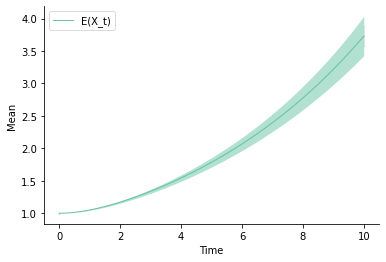

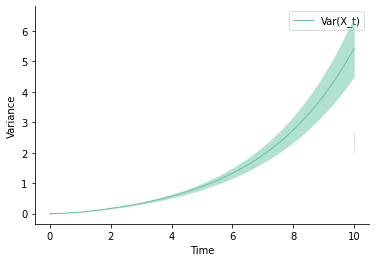

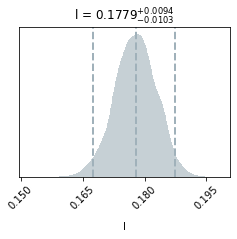

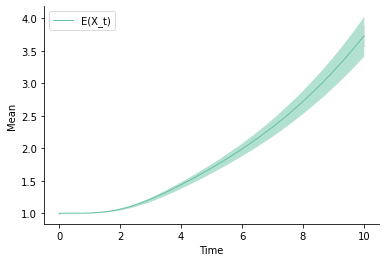

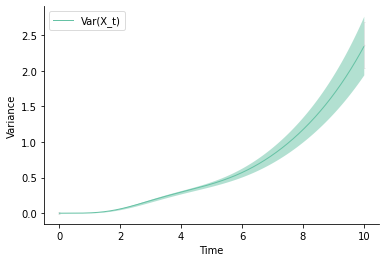

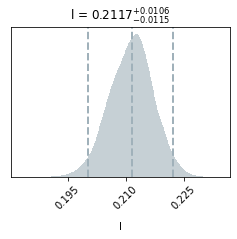

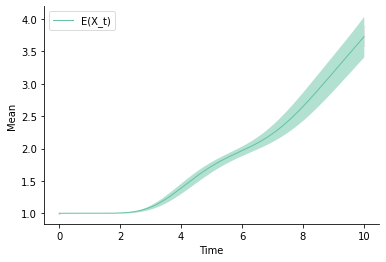

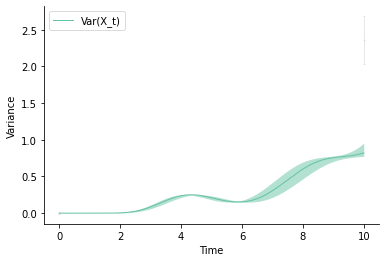

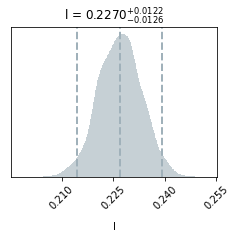

In [16]:
me.plots.est_bestfit_mean_plot(est_res_false_true[0])
me.plots.est_bestfit_variance_plot(est_res_false_true[0])
me.plots.est_corner_kernel_plot(est_res_false_true[0])

me.plots.est_bestfit_mean_plot(est_res_false_true[1])
me.plots.est_bestfit_variance_plot(est_res_false_true[1])
me.plots.est_corner_kernel_plot(est_res_false_true[1])

me.plots.est_bestfit_mean_plot(est_res_false_true[2])
me.plots.est_bestfit_variance_plot(est_res_false_true[2])
me.plots.est_corner_kernel_plot(est_res_false_true[2])

In [33]:
print(est_res_all_mean[0].data.data_variance)
print(est_res_all_mean[0].data_var_values)

print(est_res[0].data.data_variance)
print(est_res[0].data_var_values)

print(est_res_false_true[0].data.data_variance)
print(est_res_false_true[0].data_var_values)

print(est_res_true_false[0].data.data_variance)
print(est_res_true_false[0].data_var_values)

[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0. 0.]]

 [[0. 0.]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0.         2.36070707]]

 [[0.01       0.32208202]]]
[[[0. 0.]]

 [[0. 0.]]]


In [13]:
### define network
net = me.Network('net_min_2_4')
net.structure([
    {'start': 'X_t', 'end': 'Y_t',
     'rate_symbol': 'd',
     'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t',
     'rate_symbol': 'l',
     'type': 'S -> S + S', 'reaction_steps': 4}
    ])

### create data with known values
num_iter = 100
initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'d': 0.03, 'l': 0.07}
time_values = np.array([0.0, 20.0, 40.0])
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

data = me.Data('data_test_est_min_2_4')
data.load(['X_t', 'Y_t'], time_values, sims,
          bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with fixed values (from a num_iter = 100 simulation)
data.data_mean = np.array([[[1.         ,0.67       ,0.37      ],
                          [0.         ,0.45       ,1.74      ]],
                         [[0.01       ,0.0469473  ,0.04838822],
                          [0.01       ,0.07188642 ,0.1995514 ]]])
data.data_variance = np.array([[[0.         ,0.22333333 ,0.23545455],
                              [0.         ,0.51262626 ,4.03272727]],
                             [[0.01       ,0.01631605 ,0.01293869],
                              [0.01       ,0.08878719 ,0.68612036]]])
data.data_covariance = np.array([[[ 0.         ,-0.30454545 ,-0.65030303]],
                             [[ 0.01        ,0.0303608   ,0.06645246]]])

do stuff


In [14]:
### run estimation and return object
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
initial_values = {'X_t': 1, 'Y_t': 0}
theta_bounds = {'d': (0.0, 0.15), 'l': (0.0, 0.15)}
sim_mean_only = False
fit_mean_only = False

nlive = 1000 # 250 # 1000
tolerance = 0.01 # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
bound = 'multi'
sample = 'unif'

est = me.Estimation('est_min_2_4', net, data)
est.estimate(variables, initial_values, theta_bounds,
                    sim_mean_only, fit_mean_only,
                    nlive, tolerance, bound, sample)

In [17]:
print(est.bay_est_log_evidence)
print(est.bay_est_log_evidence_from_bic)
print(est.bay_est_log_likelihood_max)
print(est.bay_est_bayesian_information_criterion)
print(est.bay_est_params_cred)

28.22035278890835
32.777259111686284
35.485309312788495
-65.55451822337257
((0.028037077747577355, 0.025999237137929117, 0.03014597010607814), (0.07478943121408065, 0.06944090793090847, 0.0794181560900739))


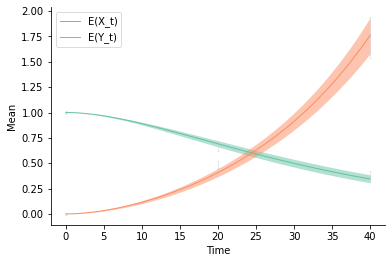

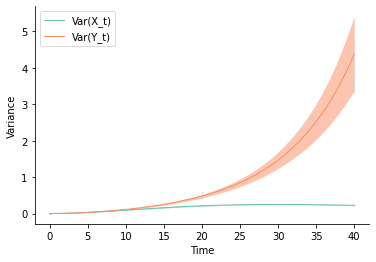

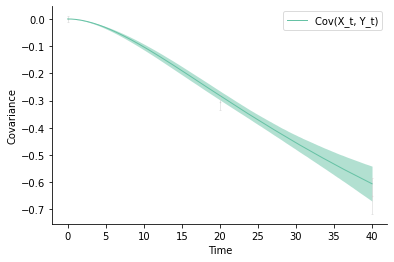

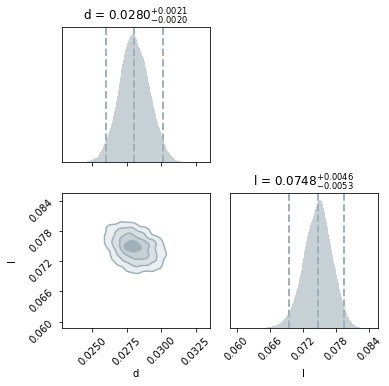

In [20]:
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)
me.plots.est_corner_kernel_plot(est)

In [32]:
def give_net(nd, nl):
    net = me.Network(f'net_min_{nd}_{nl}')
    net.structure([
        {'start': 'X_t', 'end': 'Y_t',
         'rate_symbol': 'd',
         'type': 'S -> E', 'reaction_steps': nd},
        {'start': 'Y_t', 'end': 'Y_t',
         'rate_symbol': 'l',
         'type': 'S -> S + S', 'reaction_steps': nl}
        ])
    return net
nets = [give_net(nd, nl) for nd in range(1,4) for nl in range(3,6)]
print(len(nets))

variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1, 'Y_t': 0}]*len(nets)
theta_bounds = [{'d': (0.0, 0.15), 'l': (0.0, 0.15)}]*len(nets)

est_res = me.select_models(nets, variables, initial_values,
                    theta_bounds, data, 
                    sim_mean_only=False, fit_mean_only=False,
                    parallel=False)

9


In [33]:
net_names = [est.net.net_name for est in est_res]
model_probs = me.selection.compute_model_probabilities(est_res)

print(net_names)
print([est.bay_est_log_evidence for est in est_res])
print(model_probs)

['net_min_1_3', 'net_min_1_4', 'net_min_1_5', 'net_min_2_3', 'net_min_2_4', 'net_min_2_5', 'net_min_3_3', 'net_min_3_4', 'net_min_3_5']
[27.952948623718637, 28.523931371711978, 28.606669258367557, 28.13978443248264, 28.11370656772523, 28.26176733955483, 20.03924414799428, 19.81595776867066, 19.660253130036867]
[1.18550261e-01 2.09834633e-01 2.27934349e-01 1.42903963e-01
 1.39225505e-01 1.61443579e-01 4.33535163e-05 3.46778597e-05
 2.96777260e-05]


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

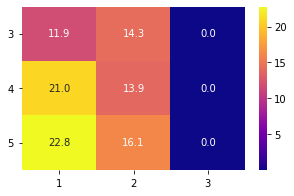

In [37]:
steps_lambda = range(3, 6)
steps_alpha = range(1, 4)
rows = [fr'$\lambda{i}$' for i in steps_lambda]
cols = [fr'$d{i}$' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_min_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(5, 3)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')

2


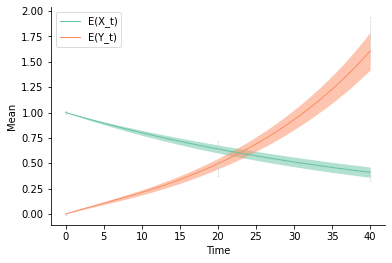

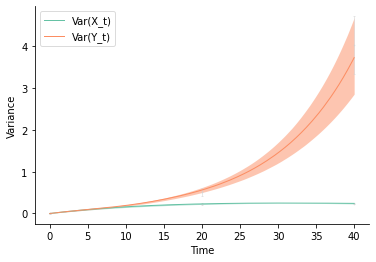

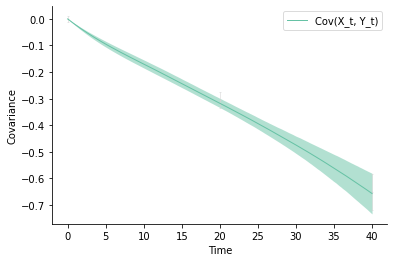

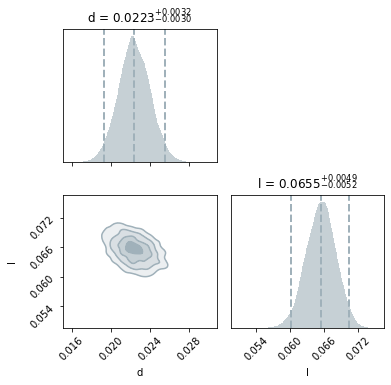

In [41]:
print(net_names.index('net_min_1_5'))
me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_bestfit_covariance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])

In [42]:
est_res_mean_only = me.select_models(nets, variables, initial_values,
                    theta_bounds, data, 
                    sim_mean_only=False, fit_mean_only=True,
                    parallel=False)

In [43]:
net_names = [est.net.net_name for est in est_res_mean_only]
model_probs = me.selection.compute_model_probabilities(est_res_mean_only)

print(net_names)
print([est.bay_est_log_evidence for est in est_res_mean_only])
print(model_probs)

['net_min_1_3', 'net_min_1_4', 'net_min_1_5', 'net_min_2_3', 'net_min_2_4', 'net_min_2_5', 'net_min_3_3', 'net_min_3_4', 'net_min_3_5']
[7.193327537317434, 7.234841406150208, 7.397485260628239, 8.059745022521886, 7.904923777418844, 7.818051878593979, 5.565342041522411, 5.228646544231574, 5.275530788426555]
[0.09964445 0.10386815 0.12221308 0.23699188 0.20299973 0.18610904
 0.01956266 0.01397021 0.01464079]


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

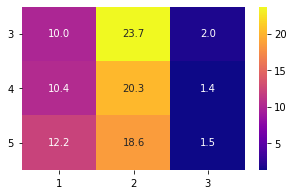

In [44]:
steps_lambda = range(3, 6)
steps_alpha = range(1, 4)
rows = [fr'$\lambda{i}$' for i in steps_lambda]
cols = [fr'$d{i}$' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_min_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(5, 3)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')

7


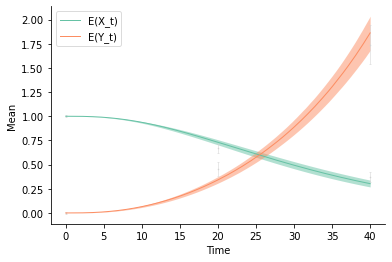

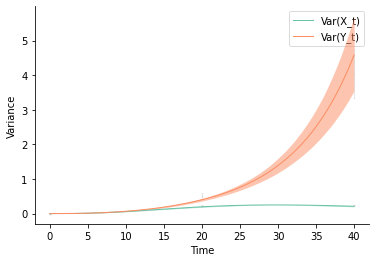

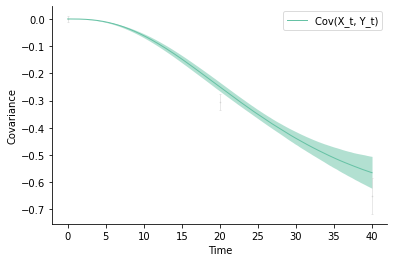

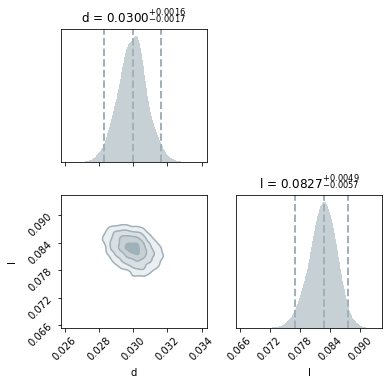

In [48]:
print(net_names.index('net_min_3_4'))
me.plots.est_bestfit_mean_plot(est_res[7])
me.plots.est_bestfit_variance_plot(est_res[7])
me.plots.est_bestfit_covariance_plot(est_res[7])
me.plots.est_corner_kernel_plot(est_res[7])

In [52]:
### run estimation and return object
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
initial_values = {'X_t': 1, 'Y_t': 0}
theta_bounds = {'d': (0.0, 0.15), 'l': (0.0, 0.15)}

for __ in range(10):
    est_mean_only = me.Estimation('est_min_2_4', net, data)
    est_mean_only.estimate(variables, initial_values, theta_bounds,
                        sim_mean_only=False, fit_mean_only=True)
    print(est_mean_only.bay_est_log_evidence)
    print(est_mean_only.bay_est_log_evidence_from_bic)
    print(est_mean_only.bay_est_log_likelihood_max)
    print(est_mean_only.bay_est_bayesian_information_criterion)
    print(est_mean_only.bay_est_params_cred)

7.7605709408748975
11.817104389040487
13.608863858268542
-23.634208778080975
((0.02837977816466184, 0.02475317184603701, 0.032252371853851), (0.07347594766652865, 0.056945734692037, 0.08750586475951816))
7.78125756882485
11.817117757230847
13.608877226458901
-23.634235514461693
((0.028306399126361383, 0.024806844409570726, 0.03231374332054859), (0.07320951510718421, 0.05693863384948446, 0.08717210242134305))
7.918132885953295
11.817088084226674
13.608847553454728
-23.634176168453347
((0.02827899953673494, 0.024841594040143064, 0.032267882689003914), (0.0730942610197843, 0.05625009927327231, 0.08742397351019225))
7.8897310484135135
11.817118059972712
13.608877529200766
-23.634236119945424
((0.02838163006364825, 0.024865759994829033, 0.03212986797543949), (0.07331954689754412, 0.05729540812526361, 0.0870374377933814))
8.007149819432435
11.817106967994976
13.60886643722303
-23.63421393598995
((0.028341976327621917, 0.024789528169831564, 0.032102435029126096), (0.07308260556778846, 0.05703

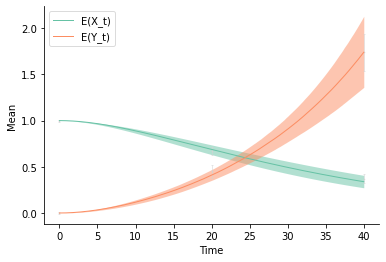

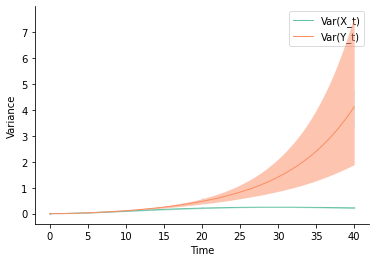

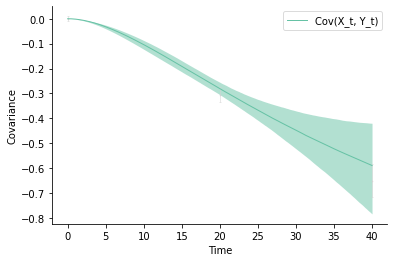

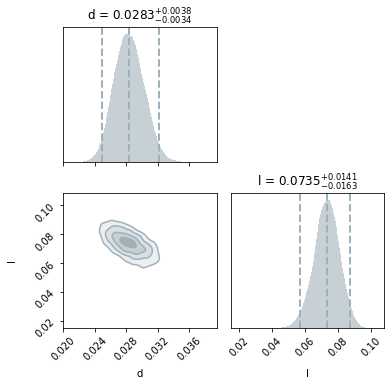

In [28]:
me.plots.est_bestfit_mean_plot(est_mean_only)
me.plots.est_bestfit_variance_plot(est_mean_only)
me.plots.est_bestfit_covariance_plot(est_mean_only)
me.plots.est_corner_kernel_plot(est_mean_only)

##### tests for data with only mean summary

In [1]:
import memo_py as me
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### define network
net = me.Network('net_min_2_4')
net.structure([
    {'start': 'X_t', 'end': 'Y_t',
     'rate_symbol': 'd',
     'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t',
     'rate_symbol': 'l',
     'type': 'S -> S + S', 'reaction_steps': 4}
    ])

### create data with known values
num_iter = 100
initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'d': 0.03, 'l': 0.07}
time_values = np.array([0.0, 20.0, 40.0])
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

data = me.Data('data_test_est_min_2_4')
data.load(['X_t', 'Y_t'], time_values, sims,
          bootstrap_samples=10000, basic_sigma=1/num_iter)

# overwrite with fixed values (from a num_iter = 100 simulation)
data.data_mean = np.array([[[1.         ,0.67       ,0.37      ],
                          [0.         ,0.45       ,1.74      ]],
                         [[0.01       ,0.0469473  ,0.04838822],
                          [0.01       ,0.07188642 ,0.1995514 ]]])
data.data_variance = np.array([[[0.         ,0.22333333 ,0.23545455],
                              [0.         ,0.51262626 ,4.03272727]],
                             [[0.01       ,0.01631605 ,0.01293869],
                              [0.01       ,0.08878719 ,0.68612036]]])
data.data_covariance = np.array([[[ 0.         ,-0.30454545 ,-0.65030303]],
                             [[ 0.01        ,0.0303608   ,0.06645246]]])

In [3]:
### run estimation and return object
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}
initial_values = {'X_t': 1, 'Y_t': 0}
theta_bounds = {'d': (0.0, 0.15), 'l': (0.0, 0.15)}

In [4]:
est_mean_only = me.Estimation('est_min_2_4', net, data)
est_mean_only.estimate(variables, initial_values, theta_bounds,
                            sim_mean_only=False, fit_mean_only=True)

In [5]:
print(est_mean_only.bay_est_log_evidence)
print(est_mean_only.bay_est_log_evidence_from_bic)
print(est_mean_only.bay_est_log_likelihood_max)
print(est_mean_only.bay_est_bayesian_information_criterion)
print(est_mean_only.bay_est_params_cred)

7.971873314652892
11.817117893877946
13.608877363106
-23.63423578775589
((0.028309798602340286, 0.024801520259495082, 0.032142846157007895), (0.07352149639903754, 0.05730153060913791, 0.08737270364852234))


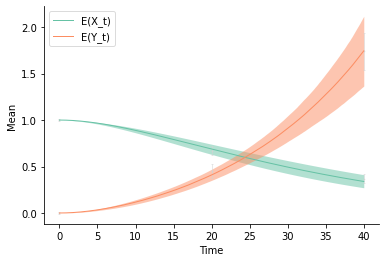

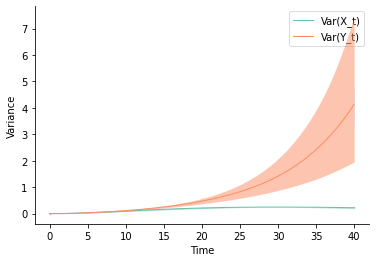

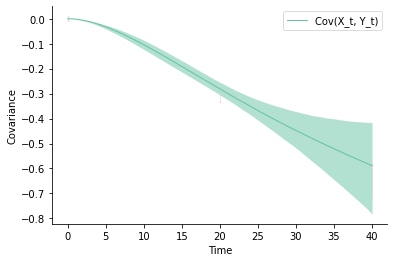

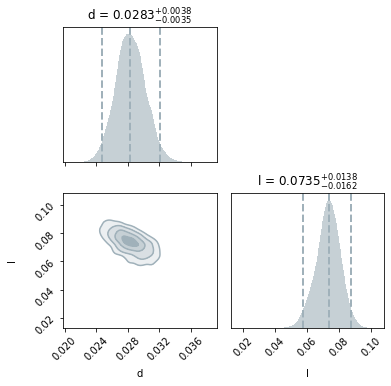

In [6]:
me.plots.est_bestfit_mean_plot(est_mean_only, cred=True)
me.plots.est_bestfit_variance_plot(est_mean_only, cred=True)
me.plots.est_bestfit_covariance_plot(est_mean_only, cred=True)
me.plots.est_corner_kernel_plot(est_mean_only)

In [7]:
### can we construct a data mean only object via summary stats?
time_values = np.array([0.0, 20.0, 40.0])
mean_data = np.array([[[1.         ,0.67       ,0.37      ],
                          [0.         ,0.45       ,1.74      ]],
                         [[0.01       ,0.0469473  ,0.04838822],
                          [0.01       ,0.07188642 ,0.1995514 ]]])

data_mean_only = me.Data('data_test_est_min_2_4')
data_mean_only.load(['X_t', 'Y_t'], time_values, None, 
                    data_type='summary', mean_data=mean_data)

In [8]:
print(data_mean_only.data_counts)
print(data_mean_only.data_mean)
print(data_mean_only.data_variance)
print(data_mean_only.data_covariance)
print(data_mean_only.data_num_variables)
print(data_mean_only.data_num_time_values)
print(data_mean_only.data_num_values)
print(data_mean_only.data_num_values_mean_only)
print(data_mean_only.data_counts.shape)
print(data_mean_only.data_variance.shape)
print(data.data_num_values)
print(data.data_num_values_mean_only)

[]
[[[1.         0.67       0.37      ]
  [0.         0.45       1.74      ]]

 [[0.01       0.0469473  0.04838822]
  [0.01       0.07188642 0.1995514 ]]]
[]
[]
2
3
6
6
(0, 2, 3)
(2, 0, 3)
15
6


In [9]:
est_data_mean_only = me.Estimation('est_min_2_4', net, data_mean_only)
est_data_mean_only.estimate(variables, initial_values, theta_bounds,
                            sim_mean_only=True, fit_mean_only=True)

In [10]:
print(est_data_mean_only.bay_est_log_evidence)
print(est_data_mean_only.bay_est_log_evidence_from_bic)
print(est_data_mean_only.bay_est_log_likelihood_max)
print(est_data_mean_only.bay_est_bayesian_information_criterion)
print(est_data_mean_only.bay_est_params_cred)

7.838047858693399
11.817116580428907
13.608876049656962
-23.634233160857814
((0.028363576113057024, 0.024762783267120912, 0.03230254775342311), (0.07326715050051659, 0.057321646964717796, 0.08748301063699494))


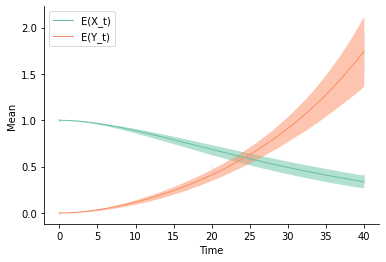

No handles with labels found to put in legend.


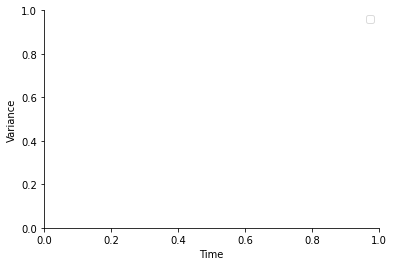

No handles with labels found to put in legend.


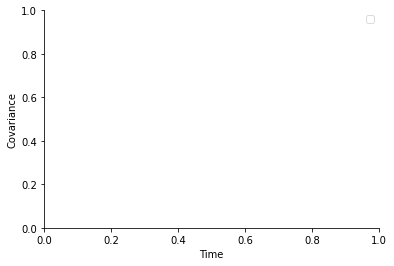

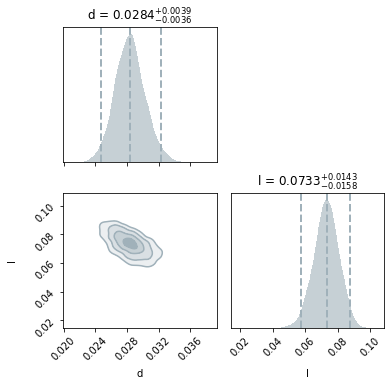

In [11]:
me.plots.est_bestfit_mean_plot(est_data_mean_only, cred=True)
me.plots.est_bestfit_variance_plot(est_data_mean_only, cred=True)
me.plots.est_bestfit_covariance_plot(est_data_mean_only, cred=True)
me.plots.est_corner_kernel_plot(est_data_mean_only)

In [12]:
est_data_mean_only = me.Estimation('est_min_2_4', net, data_mean_only)
est_data_mean_only.estimate(variables, initial_values, theta_bounds,
                            sim_mean_only=False, fit_mean_only=True)

In [13]:
print(est_data_mean_only.bay_est_log_evidence)
print(est_data_mean_only.bay_est_log_evidence_from_bic)
print(est_data_mean_only.bay_est_log_likelihood_max)
print(est_data_mean_only.bay_est_bayesian_information_criterion)
print(est_data_mean_only.bay_est_params_cred)

8.049955230513655
11.817117185654219
13.608876654882273
-23.634234371308438
((0.0282744835955443, 0.02480975336519304, 0.032168549344943974), (0.07332444717656972, 0.05728402017019692, 0.08752056055506047))


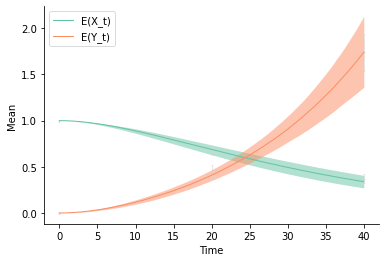

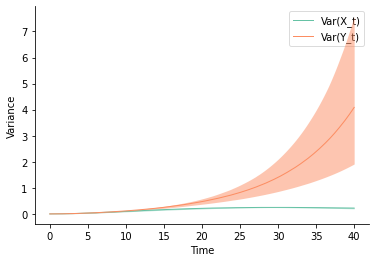

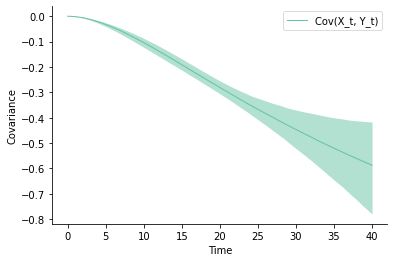

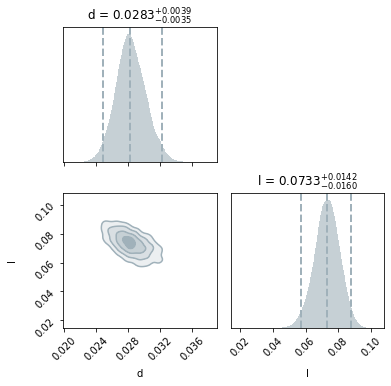

In [15]:
me.plots.est_bestfit_mean_plot(est_data_mean_only, cred=True)
me.plots.est_bestfit_variance_plot(est_data_mean_only, cred=True)
me.plots.est_bestfit_covariance_plot(est_data_mean_only, cred=True)
me.plots.est_corner_kernel_plot(est_data_mean_only)

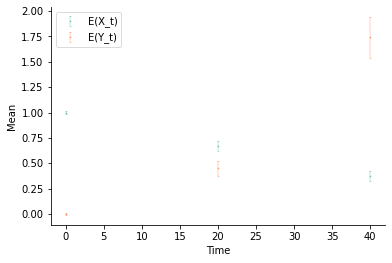

No handles with labels found to put in legend.


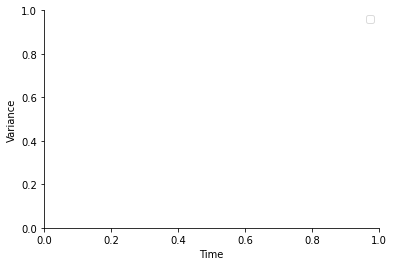

No handles with labels found to put in legend.


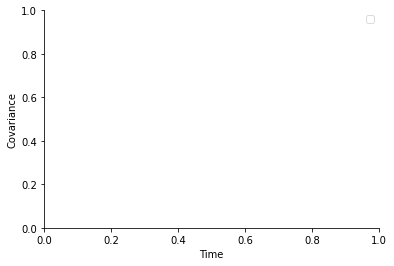

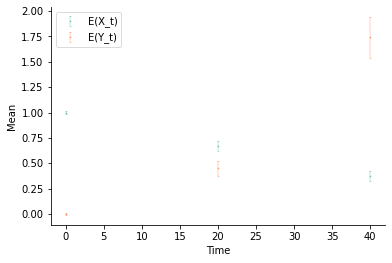

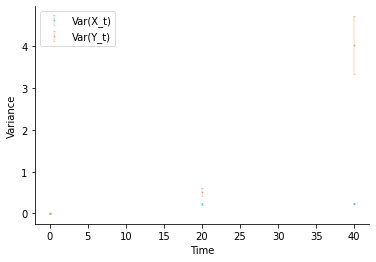

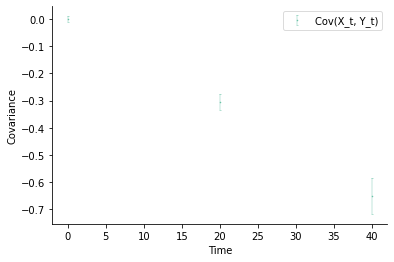

[]
[{'variables': ('X_t', 'X_t'), 'summary_indices': 0, 'count_indices': (0, 0)}, {'variables': ('Y_t', 'Y_t'), 'summary_indices': 1, 'count_indices': (1, 1)}]
[]
[{'variables': ('X_t', 'Y_t'), 'summary_indices': 0, 'count_indices': (0, 1)}]


In [21]:
me.plots.data_mean_plot(data_mean_only)
me.plots.data_variance_plot(data_mean_only)
me.plots.data_covariance_plot(data_mean_only)
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)
me.plots.data_covariance_plot(data)
print(data_mean_only.data_variance_order)
print(data.data_variance_order)
print(data_mean_only.data_covariance_order)
print(data.data_covariance_order)

In [25]:
print(est_data_mean_only.data_mean_values)
print(est_data_mean_only.data_var_values)
print(est_data_mean_only.data_cov_values)
print(est_data_mean_only.data_cov_values.shape)

print(est_mean_only.data_mean_values)
print(est_mean_only.data_var_values)
print(est_mean_only.data_cov_values)


[[[1.         0.67       0.37      ]
  [0.         0.45       1.74      ]]

 [[0.01       0.0469473  0.04838822]
  [0.01       0.07188642 0.1995514 ]]]
[]
[]
(2, 0, 3)
[[[1.         0.67       0.37      ]
  [0.         0.45       1.74      ]]

 [[0.01       0.0469473  0.04838822]
  [0.01       0.07188642 0.1995514 ]]]
[[[0.         0.22333333 0.23545455]
  [0.         0.51262626 4.03272727]]

 [[0.01       0.01631605 0.01293869]
  [0.01       0.08878719 0.68612036]]]
[[[ 0.         -0.30454545 -0.65030303]]

 [[ 0.01        0.0303608   0.06645246]]]
